# Just the Clustering part

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime, timedelta

import sys
import os
import re
import random
import importlib
import datetime as dt
import json
import logging

from tqdm import trange # For progress bars
from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')

from utils.anomalyregistry import JSONAnomalyRegistry
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton



In [2]:
# Rack color mapping
rack_colors = {  0: '#D81B60',
                 1: '#1E88E5',
                 2: '#FFC107',
                 3: '#004D40',
                 4: '#C43F42',
                 5: '#6F8098',
                 6: '#D4FC14',
                 7: '#1CB2C5',
                 8: '#18F964',
                 9: '#1164B3'}

# Set font sizes for plots
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
def get_tpu_number(channel_name):
    parameters = [int(substring) for substring in re.findall(r'\d+', channel_name)]
    return parameters[4]

def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

def get_rack_hardware_configuration(rack_number: int, variant: str = '2023'):
    
    if variant == '2018':
        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (70 <= rack_number <= 77) or\
                    (79 <= rack_number <= 90):
            return 2
        elif 16 <= rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not '
                                f'in known nodes for variant {variant}')

    # need to check this and include the rest of the years
    if variant == '2023':
        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (64 <= rack_number <= 77) or\
                    (79 <= rack_number <= 95):
            return 2
        elif rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not in known nodes for variant {variant}')
    else:
        raise NotImplementedError(f'Rack hardware configuration identification not implemented for variant {variant}')

# Briefly checking the train, test and val samples for 2023

In [4]:

dataset_path = '/eos/user/k/kstehle/atlas-hlt-datasets/test_set_dcm_rates_2023.csv'

hlt_data_pd = pd.read_csv(dataset_path, index_col=0, parse_dates=True)

variant = '2023'

tpu_labels = list(hlt_data_pd.columns.values)

In [5]:
#hlt_data_pd.describe()

In [6]:
# Just to remember how we had the racks organized in most of 2023 in the Run Control.
# This is important to know when going to Grafana to do checks.


#hlt24_cols = [col for col in hlt_data_pd.columns if 'HLT-24' in col] # Old racks usually in Sim@P1. Racks 55-62 (63 in Kubernetes mode)
#hlt28_cols = [col for col in hlt_data_pd.columns if 'HLT-28' in col] # Old racks usually in Sim@P1. Racks 44-54
#hlt32_cols = [col for col in hlt_data_pd.columns if 'HLT-32:' in col] # Bulk of the new farm. Racks 1-13, 17-26, 64-89 (no 78)
#hlt3232_cols = [col for col in hlt_data_pd.columns if 'HLT-32_32' in col] # 0% overallocation. Only racks 92 and 93
#hlt3240_cols = [col for col in hlt_data_pd.columns if 'HLT-32_40' in col] # 25% overallocation. Only racks 94 and 95
#hlt3248_cols = [col for col in hlt_data_pd.columns if 'HLT-32_48' in col] # 50% overallocation. Only racks 90 and 91

## printed_racks = set()
## for entry in hlt32_cols:
##     rack = entry.split(':')[2]  
##     if rack not in printed_racks:
##         print(f'Rack: {rack}')
##         printed_racks.add(rack)

In [7]:
# Get column names, tpu numbers, and rack number
column_names = list(hlt_data_pd.columns.values)
print(f'Channels: {len(column_names)}')

nan_amount = np.mean(np.sum(pd.isna(hlt_data_pd.to_numpy()), 1)/hlt_data_pd.shape[1])
print(f'Mean sparsity original dataset: {100*nan_amount:.3f} %')

hlt_data_pd.dropna(axis=0,
                  thresh=50,
                  inplace=True)

hlt_data_np = hlt_data_pd.to_numpy()

nan_amount = np.mean(np.sum(pd.isna(hlt_data_np), 1)/hlt_data_pd.shape[1])
print(f'Mean sparsity preprocessed: {100*nan_amount:.3f} %')

tpu_numbers = [int(extract_label(label)) for label in column_names]
rack_numbers = np.floor_divide(tpu_numbers, 1000)
hardware_configurations = [get_rack_hardware_configuration(rack_number, variant='2023') for rack_number in rack_numbers]
channel_colors = [rack_colors[config] for config in hardware_configurations]

Channels: 2618
Mean sparsity original dataset: 0.296 %
Mean sparsity preprocessed: 0.296 %


# We start looking at the clustering algorithm: DBSCAN

**Density-Based Spatial Clustering of Applications with Noise**
Groups points in a dataset that are closely packed together, based on their distance to other points.

Characteristics:
+ (+) capable of identifying clusters of any shape.
+ (+) robust to noise (good for outlier detection).
+ (+) is a parameter-free clustering algorithm (no need for # clusters).
+ (+) efficient on large datasets with a time complexity of O(n log n).

- (-) its performance can be sensitive to the choice of hyperparameters.
- (-) may perform poorly on datasets with clusters of significantly different densities. 
- (-) performance can be limited on high-dimensional data due to the "curse of dimensionality".

**eps**: maximum distance between two points for them to be considered neighbors. 
Points that are within eps distance of each other are considered part of the same cluster.

**min_samples**: minimum number of points required for a point to be considered a core point. Points that have fewer than min_samples neighbors are labeled as noise.

![DBSCAN eps dependency](./img/dbscan_eps.png)

In [20]:
#!/usr/bin/env python3

import re
import json
import logging
import multiprocessing as mp
from collections import defaultdict
from statistics import multimode


from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OrdinalEncoder


from utils.anomalyclassification import AnomalyType
from utils.variables import nan_fill_value
from utils.tqdmloggingdecorator import tqdmloggingdecorator

from abc import ABC
from collections.abc import Callable


class BaseClusteringDetector(ABC):

    def __init__(self) -> None:
        self.detection_callback = None

        self._logger = logging.getLogger(__name__)

    def register_detection_callback(self,
                                        callback: Callable) -> None:
        self.detection_callback = callback


class HLTDBSCANAnomalyDetector(BaseClusteringDetector):

    def __init__(self,
                    node_labels: list,
                    eps: float = 3,
                    min_samples: int = 4,
                    duration_threshold: int = 4,
                    output_queue = None) -> None:
        super(HLTDBSCANAnomalyDetector, self).__init__()

        self.eps = eps
        self.min_samples = min_samples
        self.duration_threshold = duration_threshold
        self.output_queue = output_queue

        self.timesteps = []
        self.node_labels = node_labels

        def parse_channel_name(channel_name):
            rack_match = re.search(r'tpu-rack-(\d+)', channel_name)
            if rack_match:
                rack_number = int(rack_match.group(1))
            else:
                raise ValueError("Rack number not found in the channel name.")
            
            tpu_match = re.search(r'pc-tdq-tpu-(\d+)', channel_name)
            if tpu_match:
                tpu_number = int(tpu_match.group(1))
            else:
                raise ValueError("TPU number not found in the channel name.")
            
            return rack_number, tpu_number

        self.machine_labels = [0]*len(node_labels)
        self.rack_labels = [0]*len(node_labels)

        for machine_index, label in enumerate(node_labels):
            self.rack_labels[machine_index], self.machine_labels[machine_index] = parse_channel_name(label)



        self.dbscan_clustering = DBSCAN(eps=self.eps,
                                        min_samples=self.min_samples)
        
        # Temporary registries used for checking if the anomalies persist
        # for longer than the set threshold

        self.anomaly_registry_general = defaultdict(int)
        self.anomaly_registry_drop_to_0 = defaultdict(int)

        self.datapoints_processed = 0

        self.memory_sizes = []


    def write_memory_size(self):
        memory_sizes = np.array(self.memory_sizes).T

        print(memory_sizes)

        memory_sizes = pd.DataFrame(memory_sizes,
                                        columns=['Memory'])

        memory_sizes.to_csv('memory_dbscan.csv')


    @tqdmloggingdecorator
    def process(self,
                    timestep,
                    data: np.array) -> None:

        self.timesteps.append(timestep)

        subgroup_buckets = defaultdict(list)

        indices_nan = np.isnan(data)
        indices_not_nan = ~indices_nan

        rack_labels_filtered = np.array(self.rack_labels)[indices_not_nan]
        machine_labels_filtered = np.array(self.machine_labels)[indices_not_nan]
        data_filtered = data[indices_not_nan]

        #print(rack_labels_filtered)
        #print(machine_labels_filtered)
        #print(np.array(list(zip(rack_labels_filtered, data_filtered))))
        
        cluster_predictions =\
            self.dbscan_clustering.fit_predict(
                        np.array(list(zip(rack_labels_filtered, data_filtered))))

        #data_filtered = np.array(data_filtered).reshape(-1, 1)
        #cluster_predictions = self.dbscan_clustering.fit_predict(data_filtered)
        
        print(cluster_predictions)
        # memory_size = deep_sizeof(self.dbscan_clustering, with_overhead=True, verbose=True)
        # self.memory_sizes.append(memory_size)

        for machine_index, datapoint in enumerate(data_filtered):

            subgroup_buckets[rack_labels_filtered[machine_index]].append(
                                        [machine_labels_filtered[machine_index],
                                            datapoint,
                                            cluster_predictions[machine_index]])

        # Predict subgroup anomalies using per-rack cluster membership

        for subgroup, subgroup_bucket in subgroup_buckets.items():
            
            machine_labels_cluster, datapoints, cluster_predictions = map(list, zip(*subgroup_bucket))

            multimode_rack_bucket = multimode(cluster_predictions)
            largest_cluster_membership = multimode_rack_bucket[0]

            y_predicted = np.array([0 if cluster_prediction == largest_cluster_membership \
                                        else 1 for cluster_prediction in cluster_predictions], np.byte)

            for machine_label, datapoint, y in zip(machine_labels_cluster, datapoints, y_predicted):

                if y == 1:
                    if np.isclose(datapoint, 0):
                        self.anomaly_registry_drop_to_0[machine_label] += 1
                        self.anomaly_registry_general.pop(machine_label, None)
                    elif np.isclose(datapoint, nan_fill_value):
                        self.anomaly_registry_drop_to_0.pop(machine_label, None)
                        self.anomaly_registry_general.pop(machine_label, None)
                    else:
                        self.anomaly_registry_general[machine_label] += 1
                        self.anomaly_registry_drop_to_0.pop(machine_label, None)
                else:
                    self.anomaly_registry_drop_to_0.pop(machine_label, None)
                    self.anomaly_registry_general.pop(machine_label, None)

        # Add subgroups that show anomalous behavior for longer than the
        # set threshold to the persistent anomaly registry

        cluster_anomaly_set = set()

        for machine_label, anomaly_duration in self.anomaly_registry_general.items():
            anomaly_start = self.timesteps[self.datapoints_processed - anomaly_duration + 1].strftime('%Y-%m-%d %H:%M:%S')

            if anomaly_duration == self.duration_threshold:
                 self._logger.warning(f'{machine_label}: General anomaly encountered '
                                            f'at element {self.datapoints_processed}')

            if anomaly_duration >= self.duration_threshold:
                self.detection_callback(int(machine_label),
                                            AnomalyType.ClusteringGeneral,
                                            anomaly_start,
                                            anomaly_duration)

                cluster_anomaly_set.add(machine_label//1000)

        for machine_label, anomaly_duration in self.anomaly_registry_drop_to_0.items():
            anomaly_start = self.timesteps[self.datapoints_processed - anomaly_duration + 1].strftime('%Y-%m-%d %H:%M:%S')

            if anomaly_duration == self.duration_threshold:
                 self._logger.warning(f'{machine_label}: dropped to 0 '
                                        f'at element {self.datapoints_processed}')

            if anomaly_duration >= self.duration_threshold:
                self.detection_callback(int(machine_label),
                                            AnomalyType.ClusteringDropToZero,
                                            anomaly_start,
                                            anomaly_duration)

                cluster_anomaly_set.add(machine_label//1000)

        self.datapoints_processed += 1

        if self.output_queue is not None:
            self.output_queue.put(cluster_anomaly_set)



In [21]:
# Instanciate the DBSCAN anomaly detection
m_dbscan_eps = 3
m_dbscan_min_samples = 4
m_dbscan_duration_threshold = 4

dbscan_anomaly_detector = HLTDBSCANAnomalyDetector(tpu_labels,
                                                   m_dbscan_eps,
                                                   m_dbscan_min_samples,
                                                   m_dbscan_duration_threshold)

We should remember the **curse of dimensionality** <br/>

For a randomly chosen point, the relative difference between the furthest-neighbor distance and nearest-neighbor distance goes to zero as the dimensionality grows.

![Data sparsity](./img/data_sparsity.png)

In [22]:
# Dir to save the json files
output_dir = "output_notebook"

json_anomaly_registry = JSONAnomalyRegistry(output_dir)

# We'll process this in the loop just afterwards.
dbscan_anomaly_detector.register_detection_callback(
                        json_anomaly_registry.clustering_detection)

timestamps = list(hlt_data_pd.index)

# We're using the test dataset that we loaded before
hlt_data_np = hlt_data_pd.to_numpy()

In [23]:
# Here we do the loop and for each timestamp we perform the clustering. 
# We're not including the DeepLearning part. See below

with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            dbscan_anomaly_detector.process(timestamp, data)            
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("test_dataset")

  0%|          | 0/24018 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

50015: dropped to 0 at element 62


[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 0 0 0]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 0 0 0]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ...

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 3 3 3]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


KeyboardInterrupt: 

There are 2 types of anomalies.
- General Anomaly: This is when a tpu rate differs from the rest
- Dropped to 0: When a tpu rate goes to 0 when the rest has a value ( don't confuse this with L1 rate going to 0)

# Getting the plots for test dataset we checked before.

If you use this code with individual runs, it will woork too.

In [28]:
# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        machine_name = machine_name.zfill(5)  # Ensure machine ID has 5 digits
        intervals[machine_name] = []
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (remember that each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals


# Define a color palette for different machines
colors = list(mcolors.TABLEAU_COLORS.values())

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str or tuple): Matplotlib color
    amount (float): Amount to lighten the color (0 to 1)
    
    Returns:
    tuple: Lightened color
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    white = np.array([1, 1, 1, 1])
    return tuple((1 - amount) * np.array(c) + amount * white)

def plot_run(run_number, pdf=None):
    # Load JSON anomaly data
    if run_number == "test" or run_number == "train" or run_number == "val":
        json_file = f'output_notebook/{run_number}_dataset.json'
        csv_file = dataset_path
    else:
        json_file = f'output_notebook/run_{run_number}.json'
        csv_file = f'data/hlt_data_pd_{run_number}.csv'

    if not os.path.exists(json_file) or not os.path.exists(csv_file):
        print(f"Missing files for run number {run_number}")
        return

    with open(json_file, 'r') as file: 
        anomaly_data = json.load(file)


    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    # Ensure the DataFrame index is timezone-aware
    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
    
    # Extract intervals for all machines
    intervals = extract_intervals_for_all_machines(anomaly_data)

    # Plotting the time series data for all machines with anomalies
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    ax.set_xlabel('Time')
    ax.set_ylabel('DCM rate [kHz]')
    ax.set_title(f'Time Series Data for Run {run_number}')
    ax.set_ylim(-1, 60)
    ax.grid()

    legend_entries = set()

    # Plot each column for each machine with anomalies and an extra machine just to compare
    for idx, (machine_id, machine_intervals) in enumerate(intervals.items()):
        color = colors[idx % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        # Plot the actual machine with anomalies
        for column in machine_columns:
            label = extract_label(column)
            ax.plot(dataset_df.index, dataset_df[column], label=f'Node - {label}', color=color)
        
        # Find an extra machine with the same starting number but not in the JSON file   
        machine_prefix = str(machine_id)[:2]
        possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
        if possible_extra_machines:
            extra_column = random.choice(possible_extra_machines)
            label = extract_label(extra_column)
            ax.plot(dataset_df.index, dataset_df[extra_column], label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

        # Overlay unique anomalies
        for start, end, anomaly_type in machine_intervals:
            anomaly_color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
            if anomaly_type not in legend_entries:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1, label=anomaly_type)
                legend_entries.add(anomaly_type)
            else:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1)
                
            # Add text annotation for machine_id
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()
    
    if pdf:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

def plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf=None):
    # Define the zoom window duration (e.g., 5 minutes before and after the anomaly)
    zoom_window = timedelta(minutes=5)
    
    for machine_id, machine_intervals in intervals.items():
        color = colors[hash(machine_id) % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        for start, end, anomaly_type in machine_intervals:
            fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
            ax.set_xlabel('Time')
            ax.set_ylabel('DCM rate [kHz]')
            ax.set_title(f'Zoomed Anomaly for Run {run_number} - Node {machine_id}')
            ax.set_ylim(-1, 60)
            ax.grid()
            
            zoom_start = start - zoom_window
            zoom_end = end + zoom_window
            
            # Plot the machine's data within the zoom window
            for column in machine_columns:
                label = extract_label(column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node - {label}', color=color)
            
            # Find an extra machine with the same starting number but not in the JSON file
            machine_prefix = str(machine_id)[:2]
            possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
            if possible_extra_machines:
                extra_column = random.choice(possible_extra_machines)
                label = extract_label(extra_column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, extra_column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

            # Overlay the anomaly interval
            ax.axvspan(start, end, color='red' if anomaly_type == 'ClusteringDropToZero' else 'blue', alpha=0.5, zorder=1, label=anomaly_type)
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)
            

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
            fig.autofmt_xdate()

            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

            plt.tight_layout()

            if pdf:
                pdf.savefig(fig)
                plt.close(fig)
            else:
                plt.show()



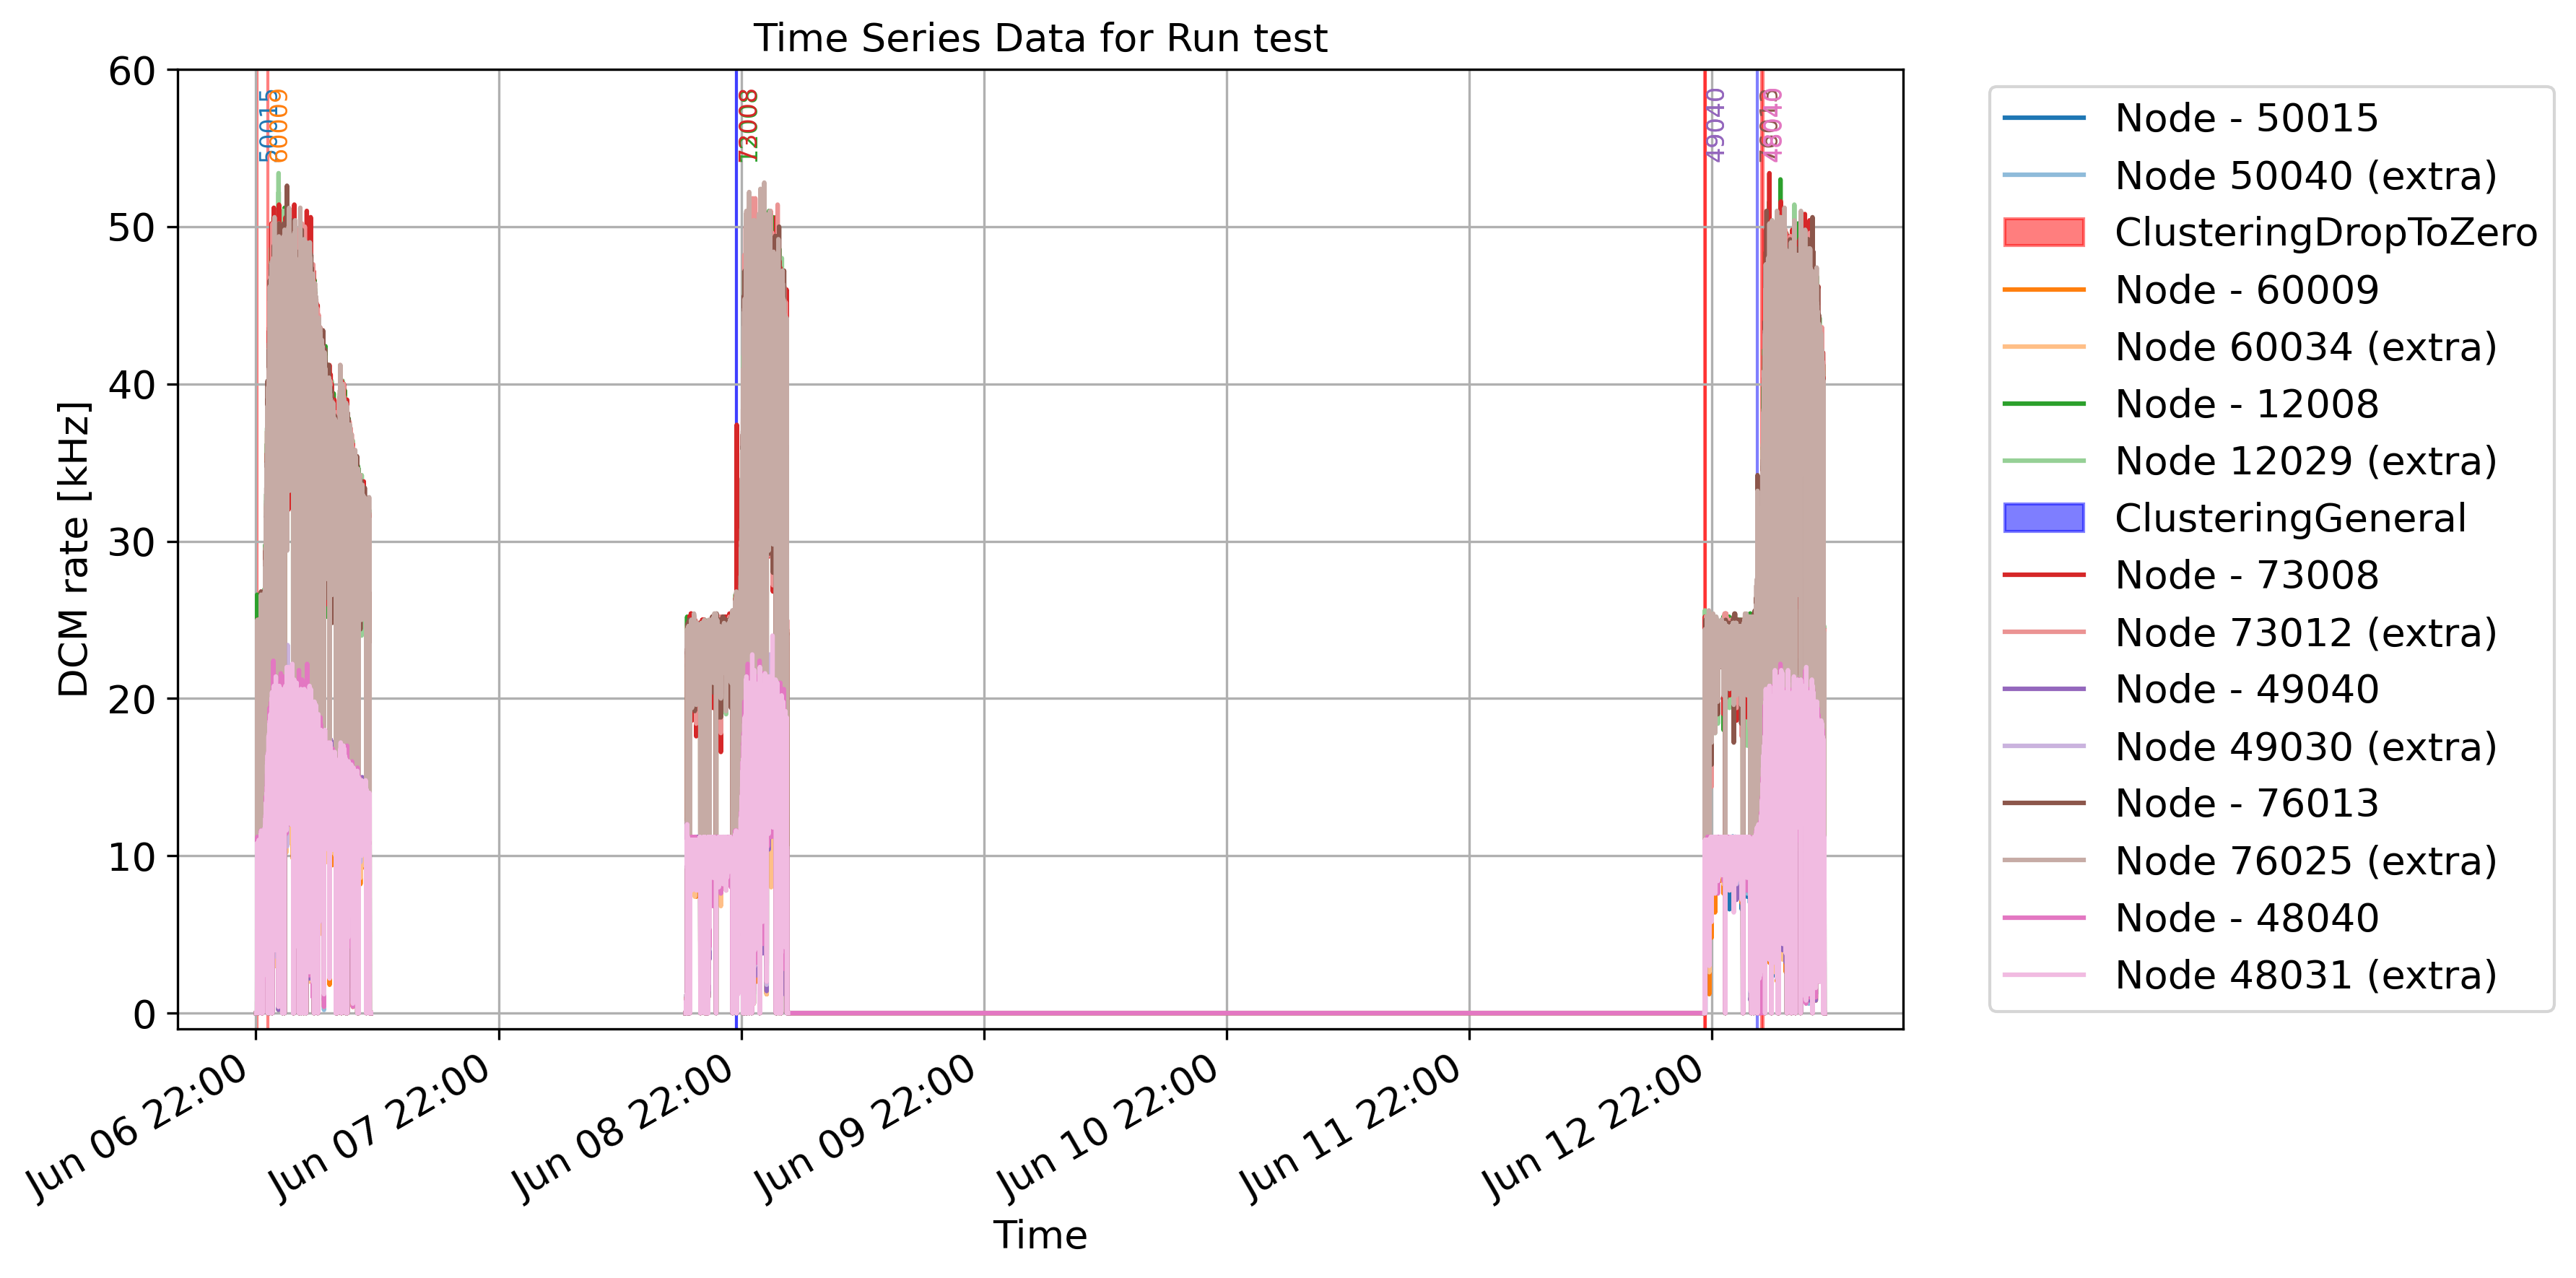

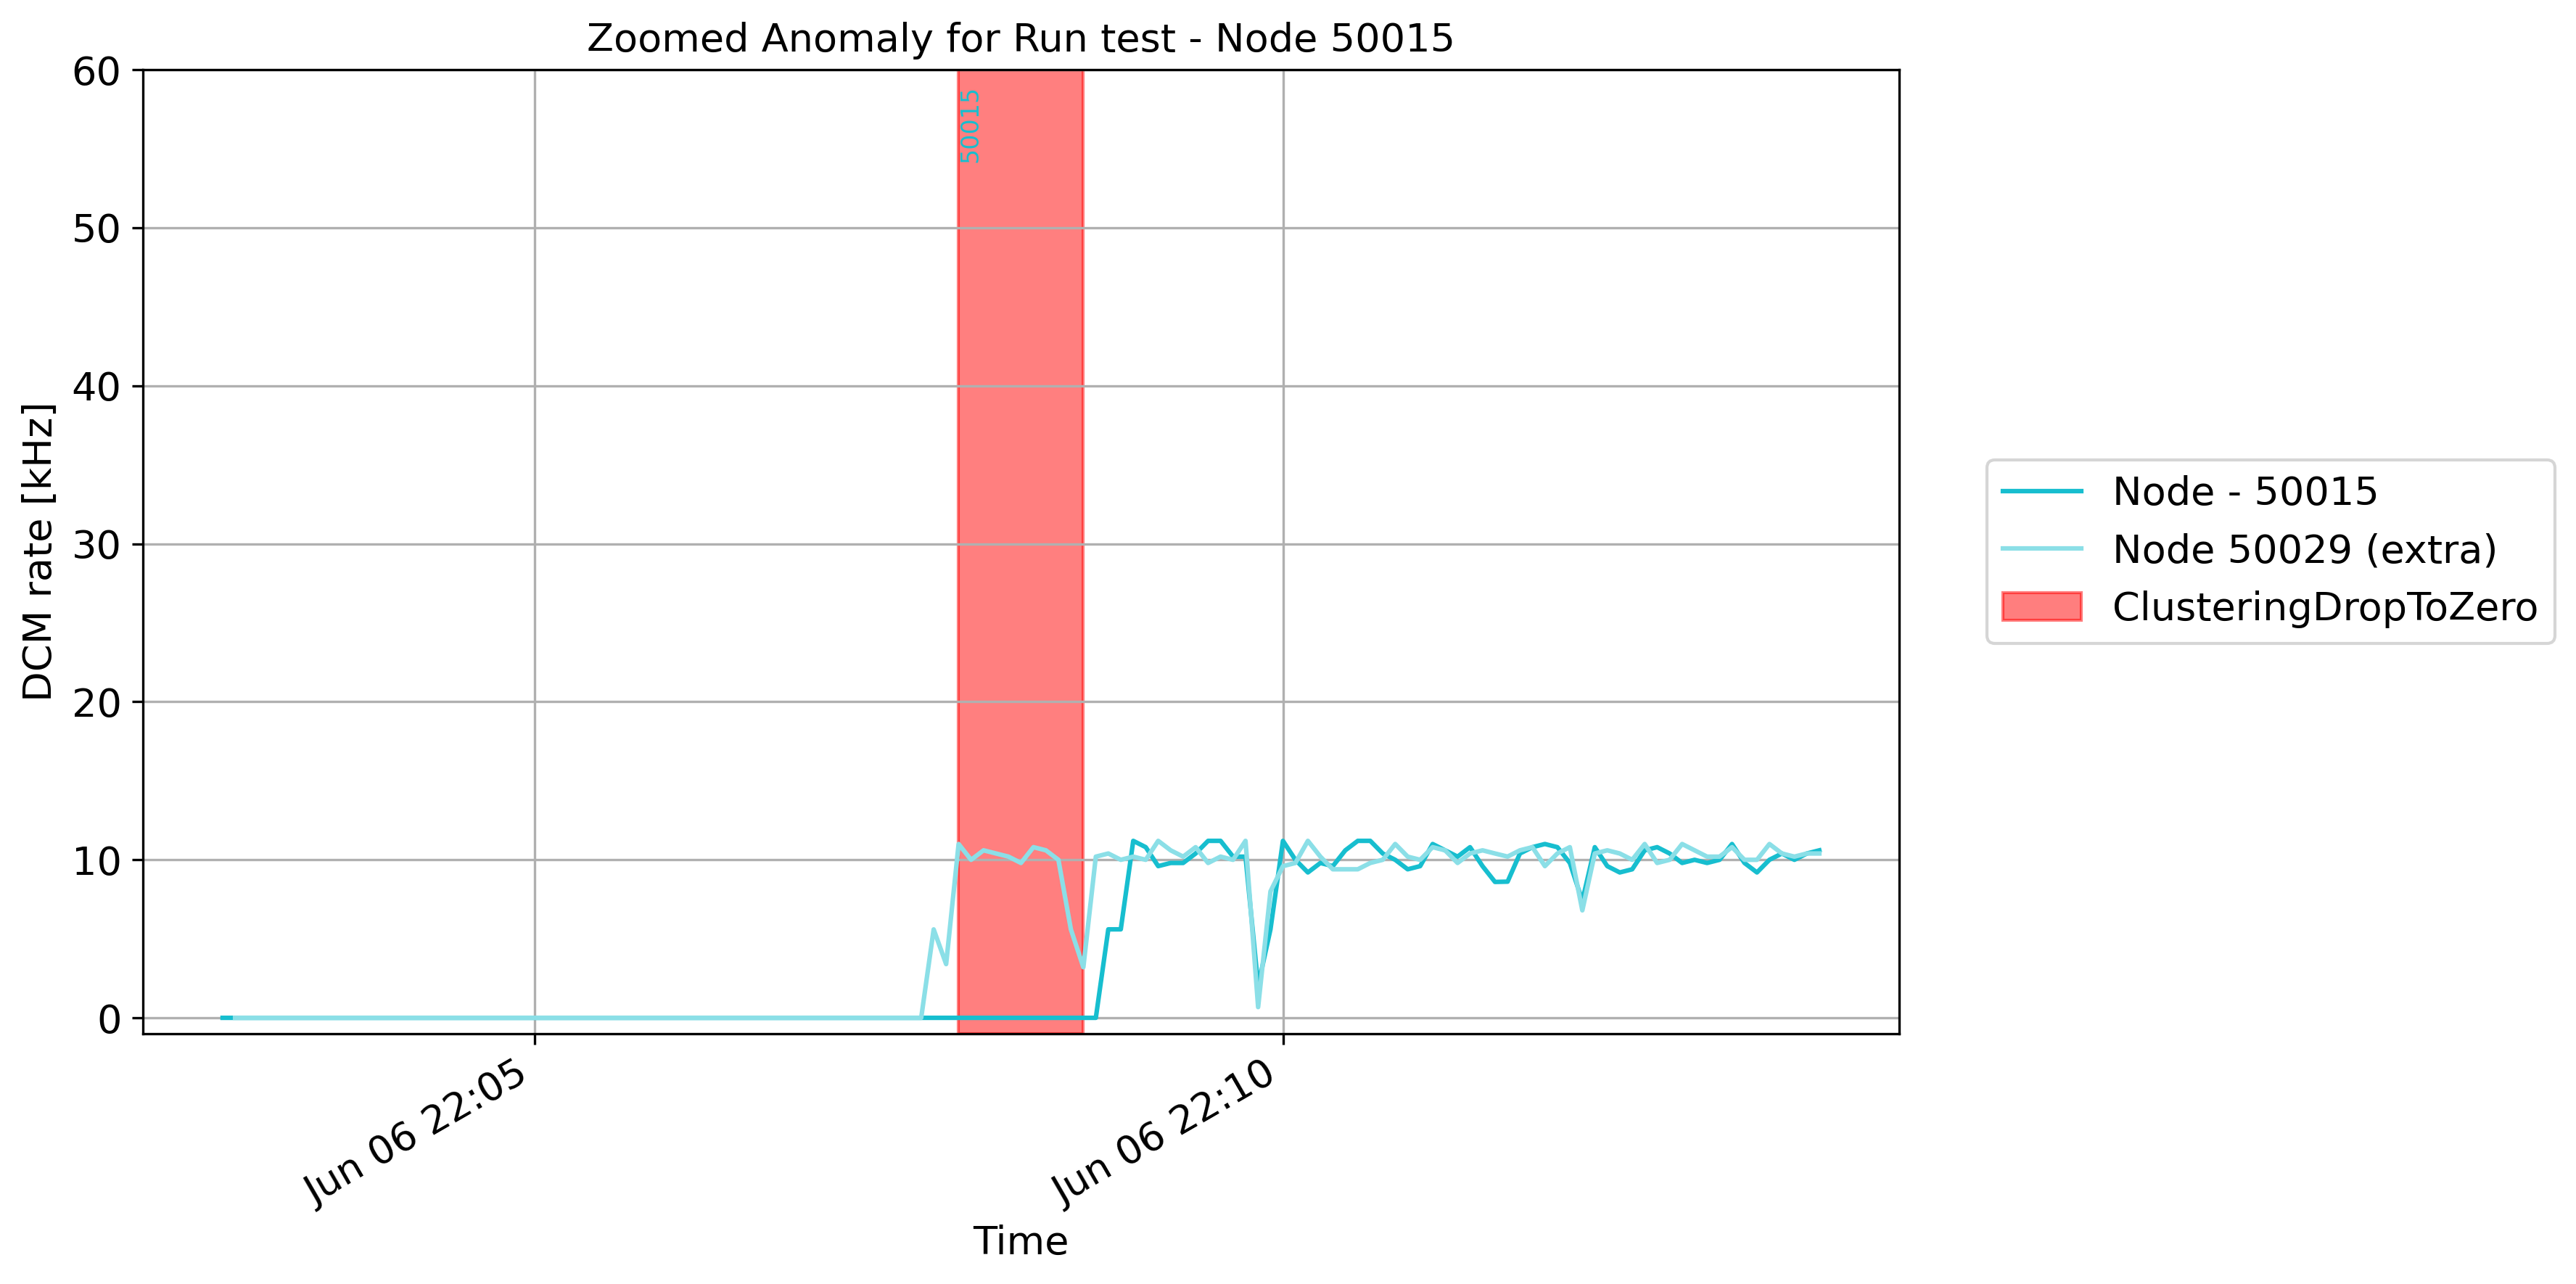

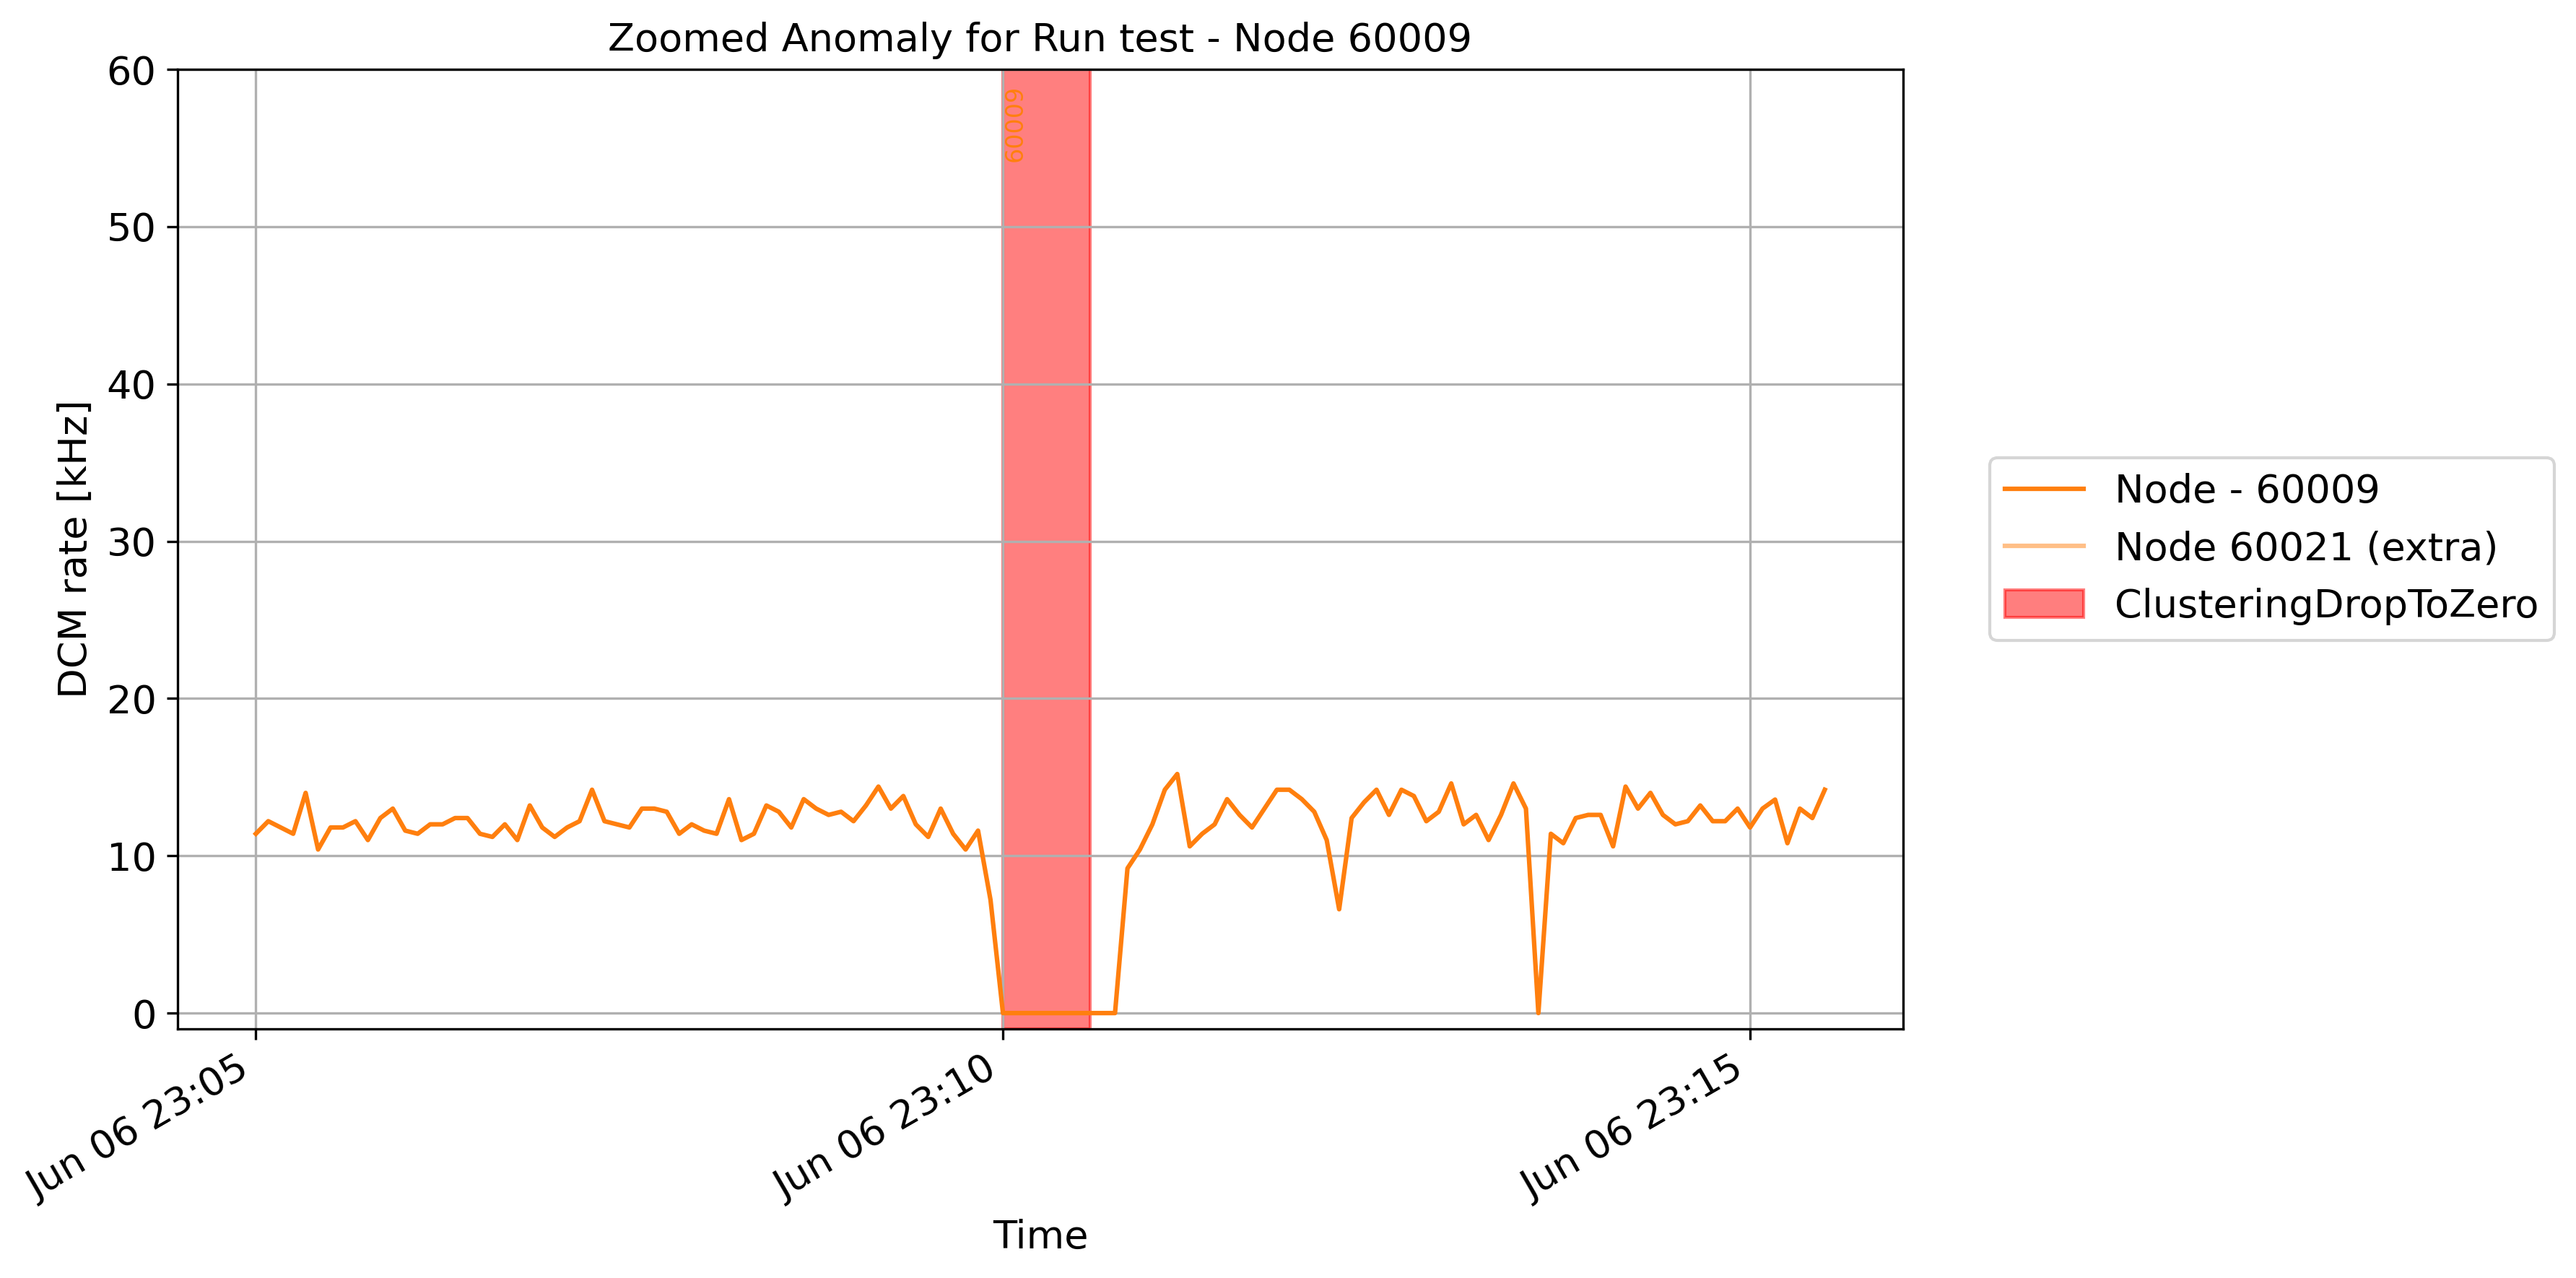

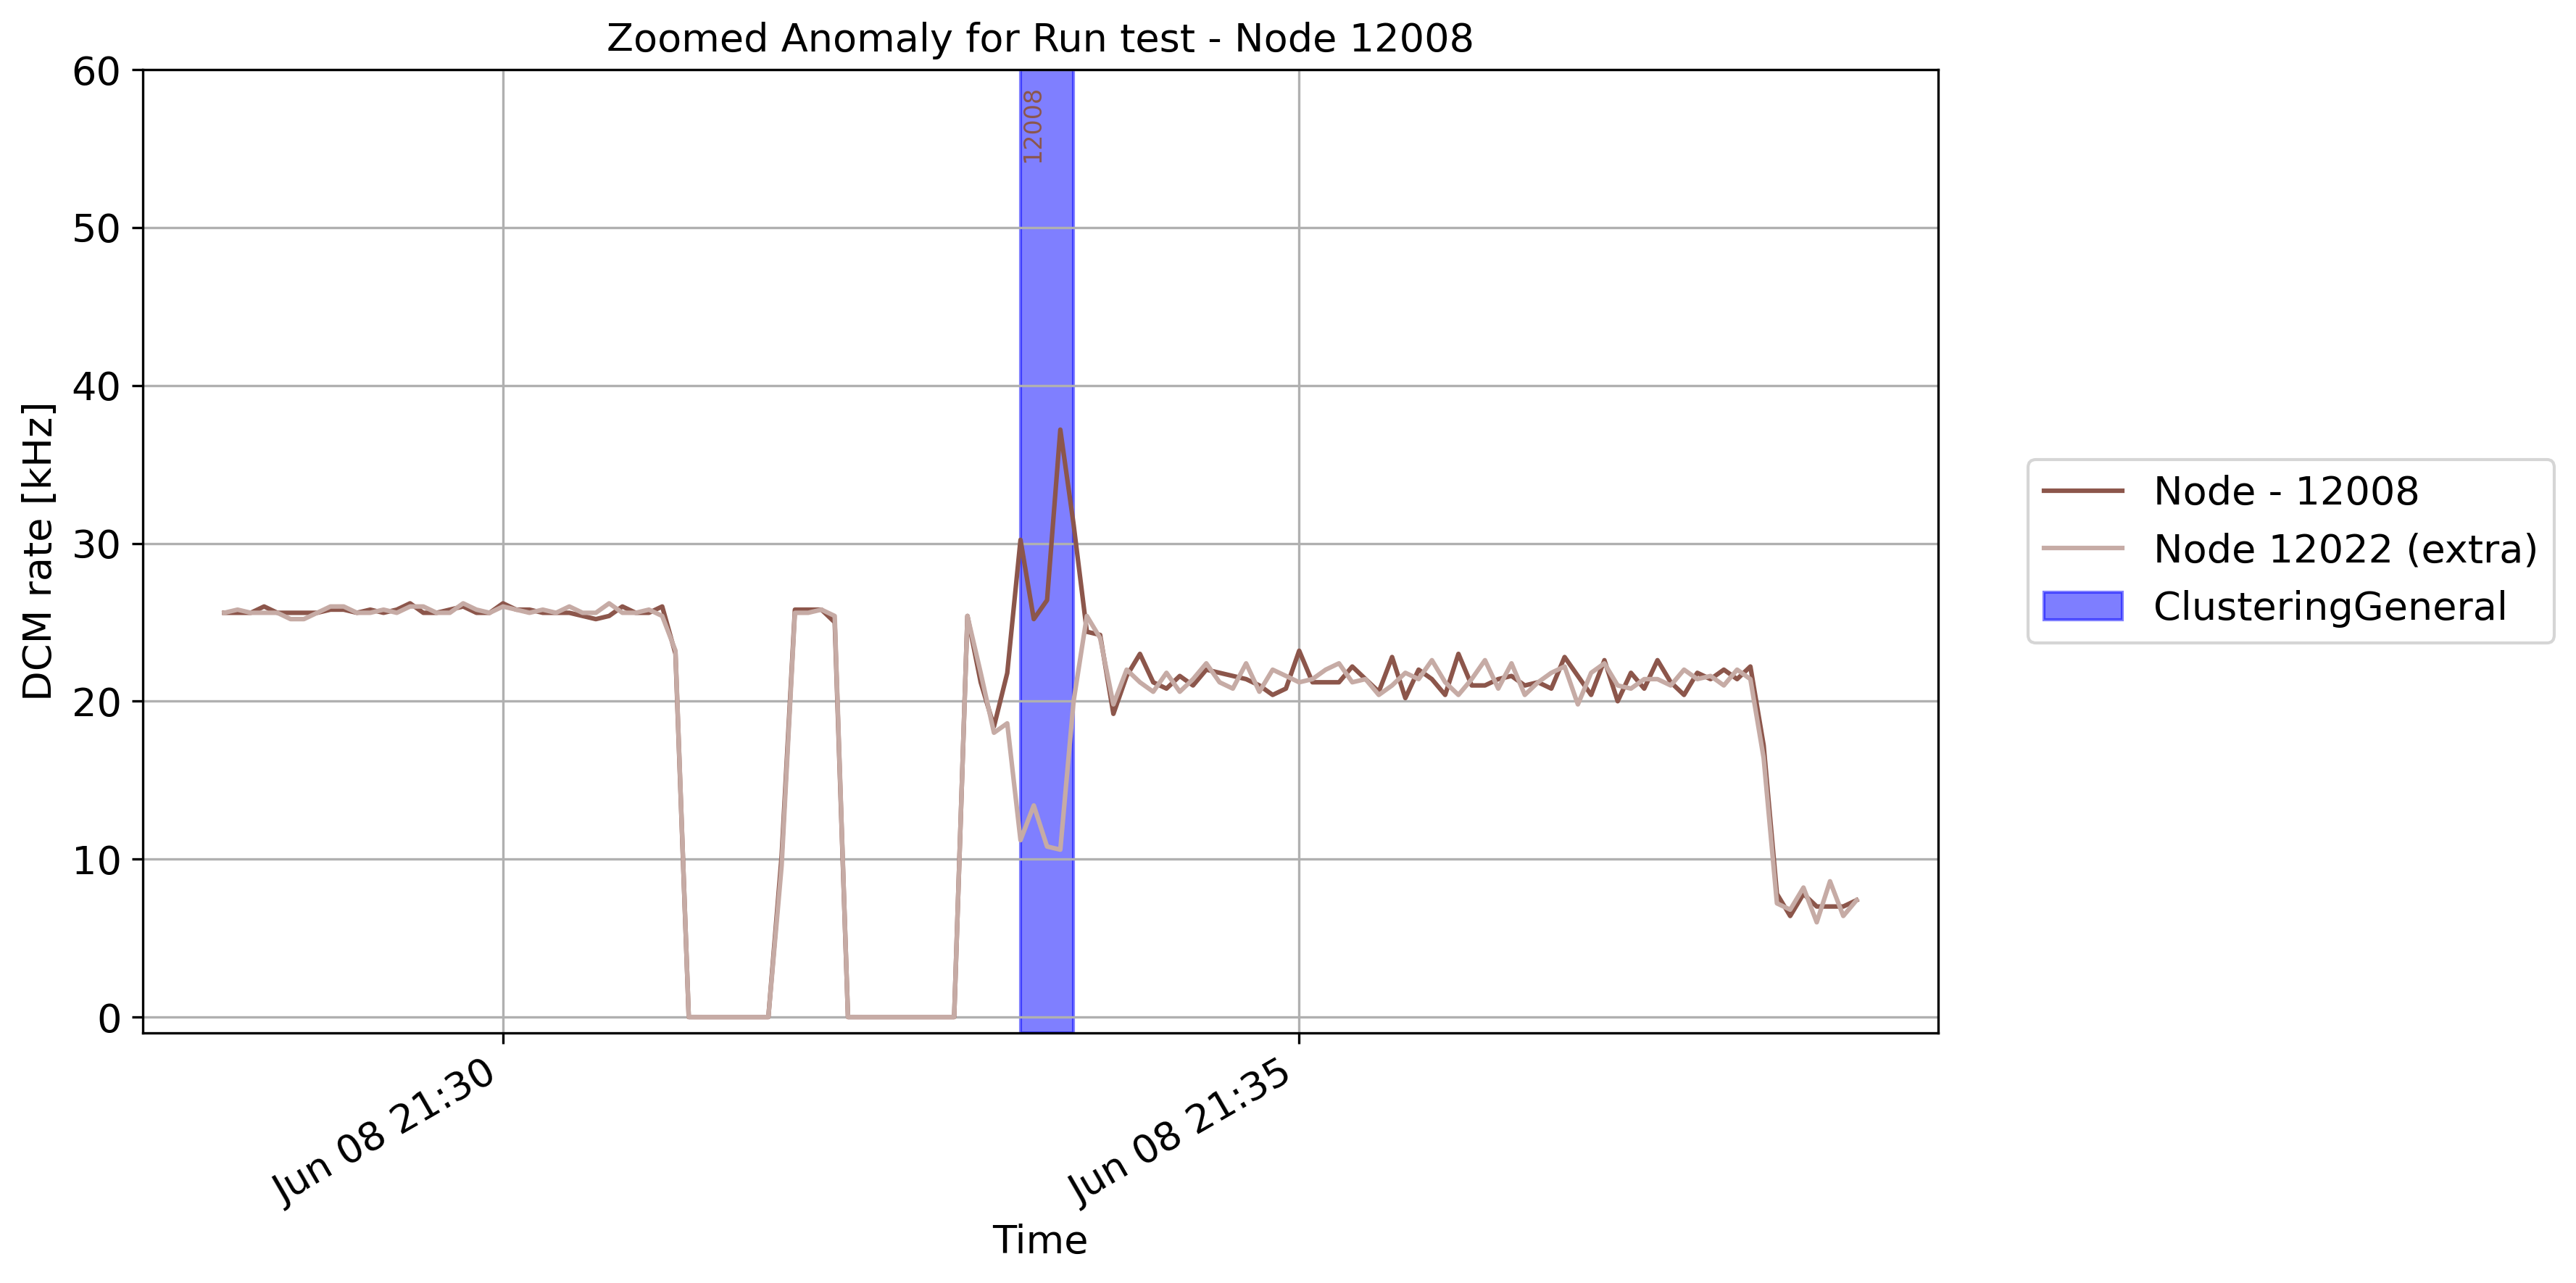

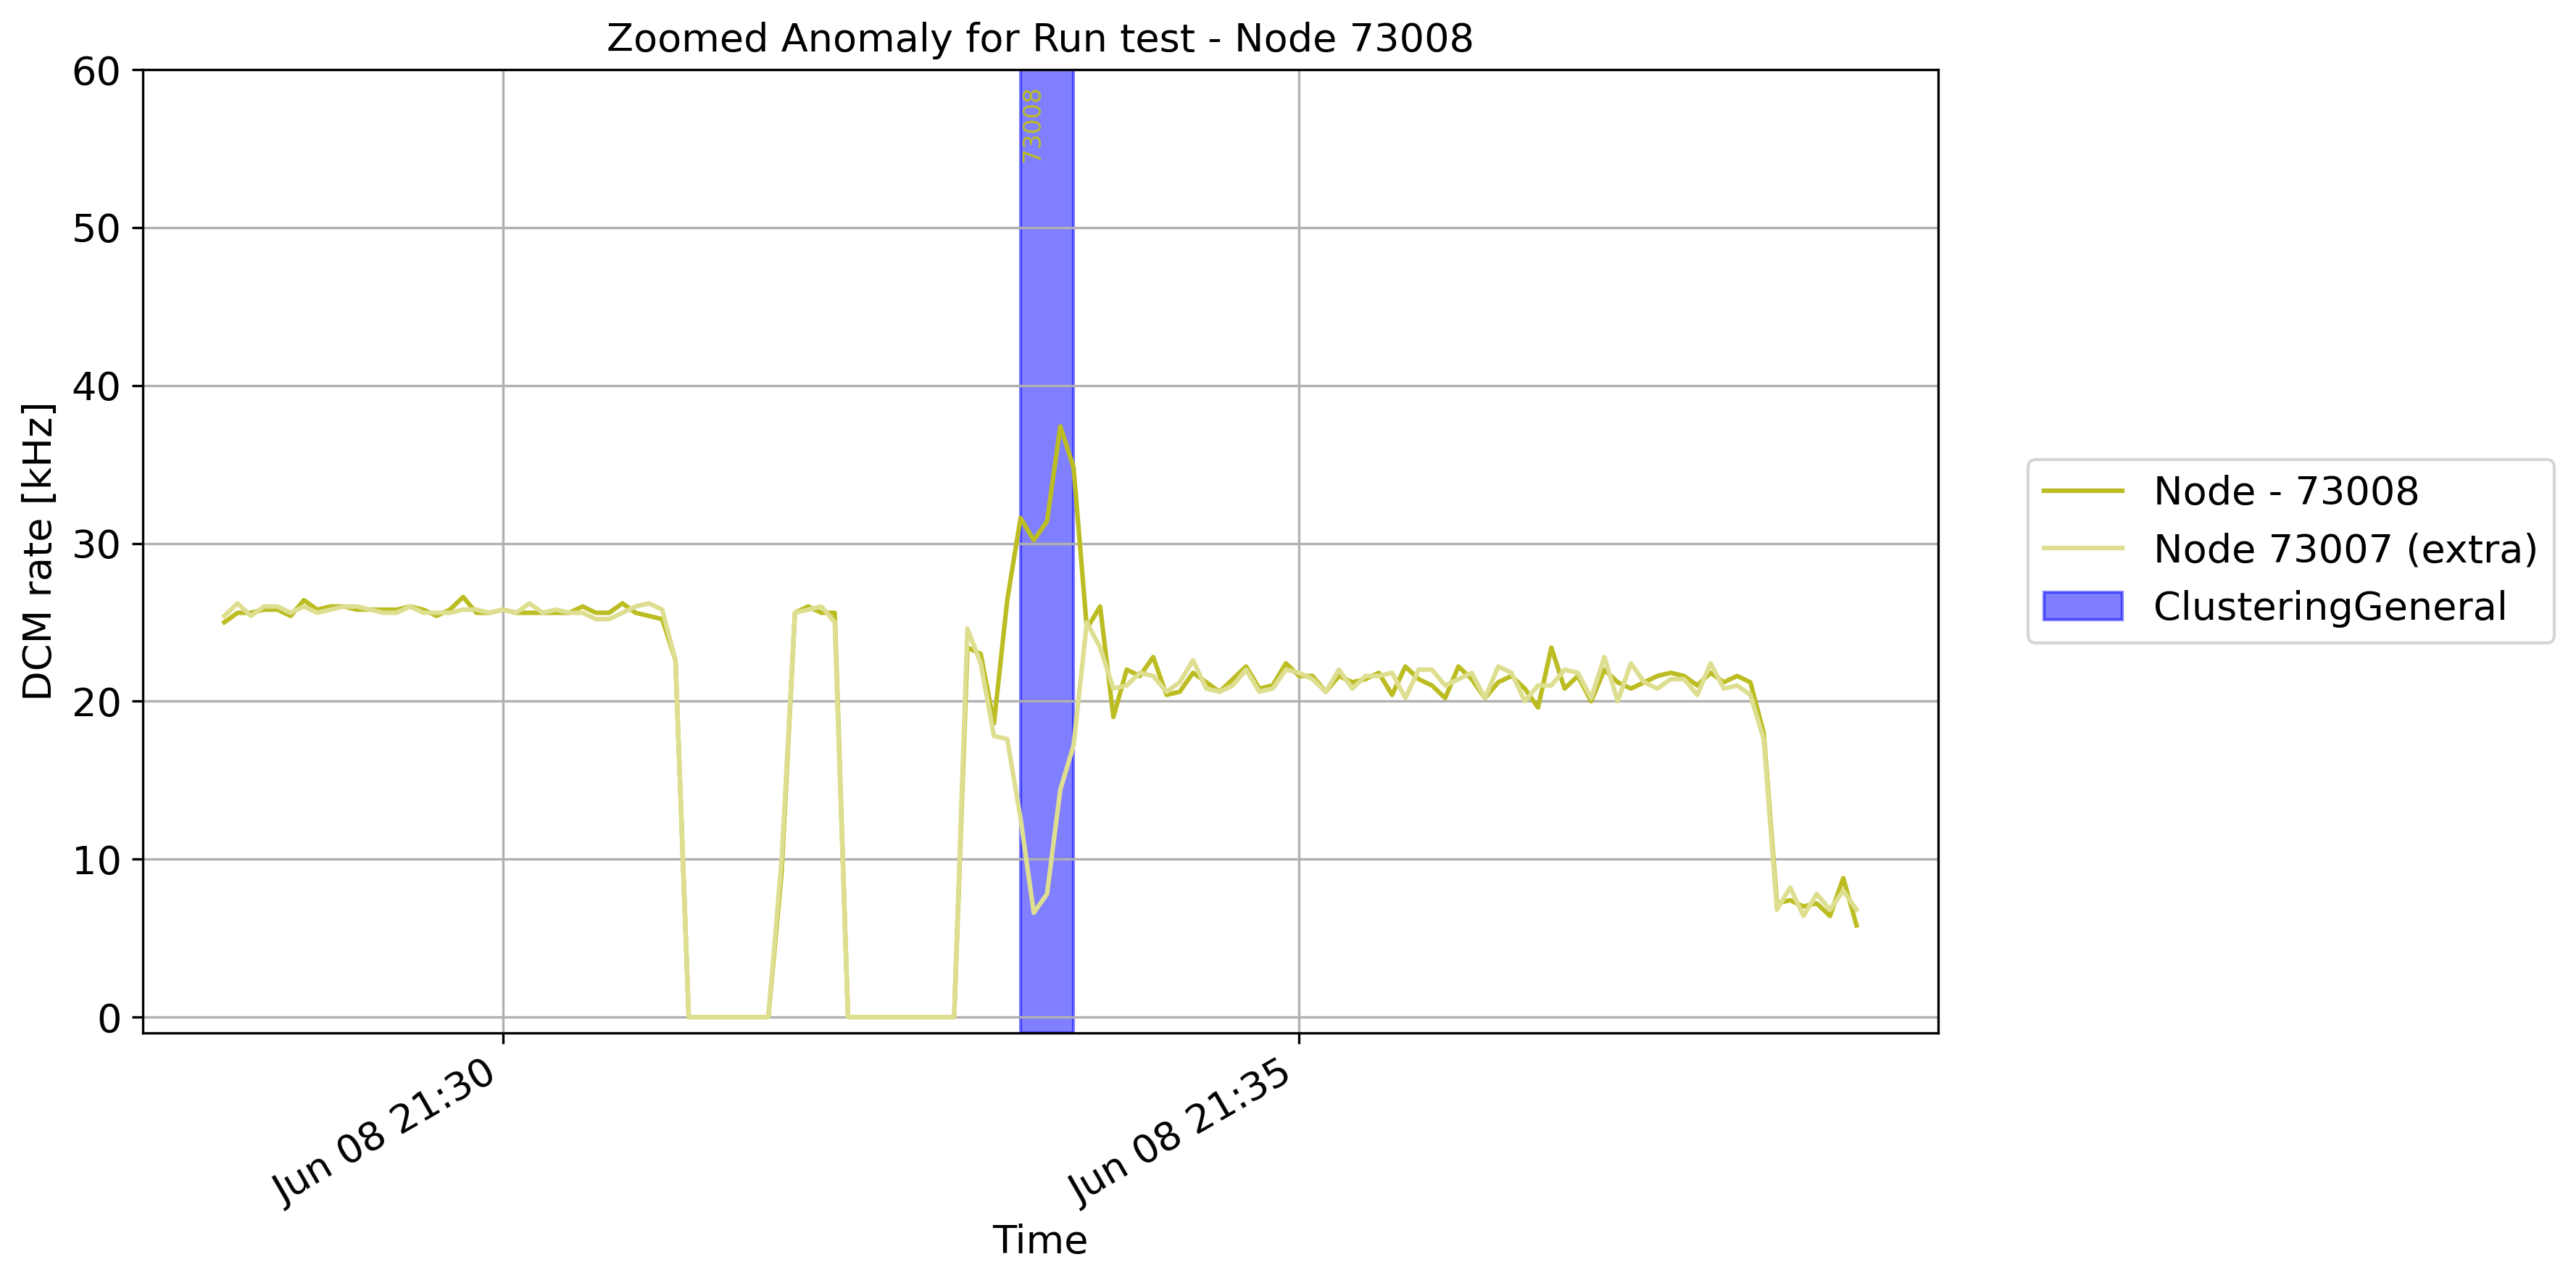

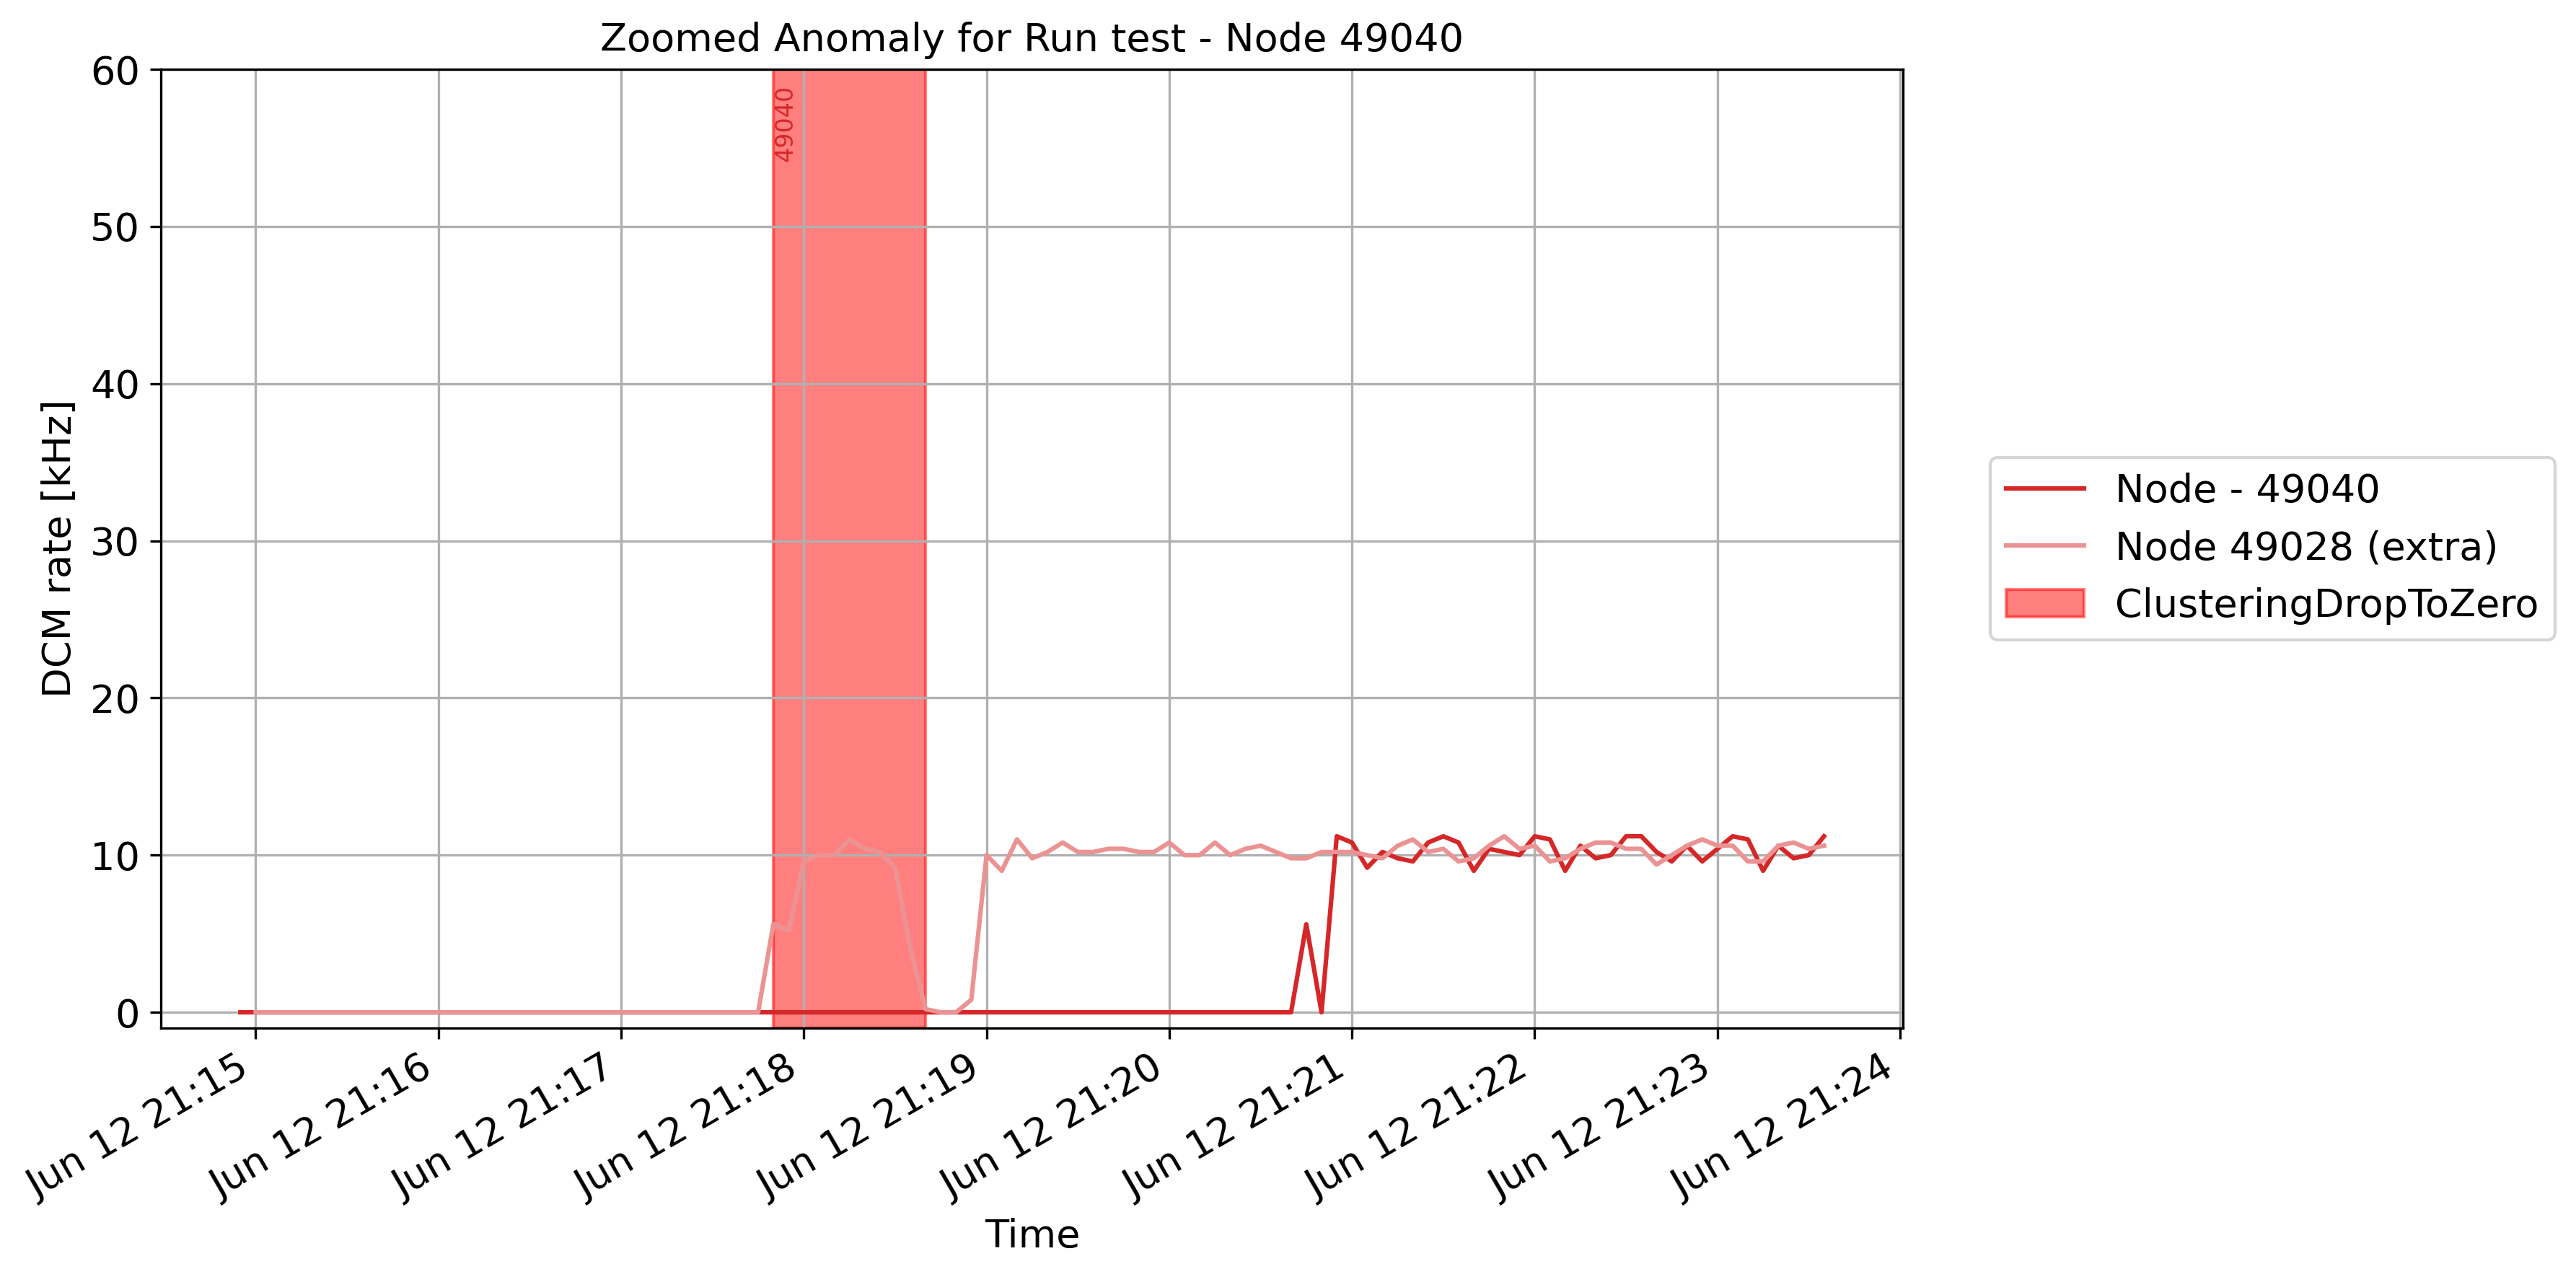

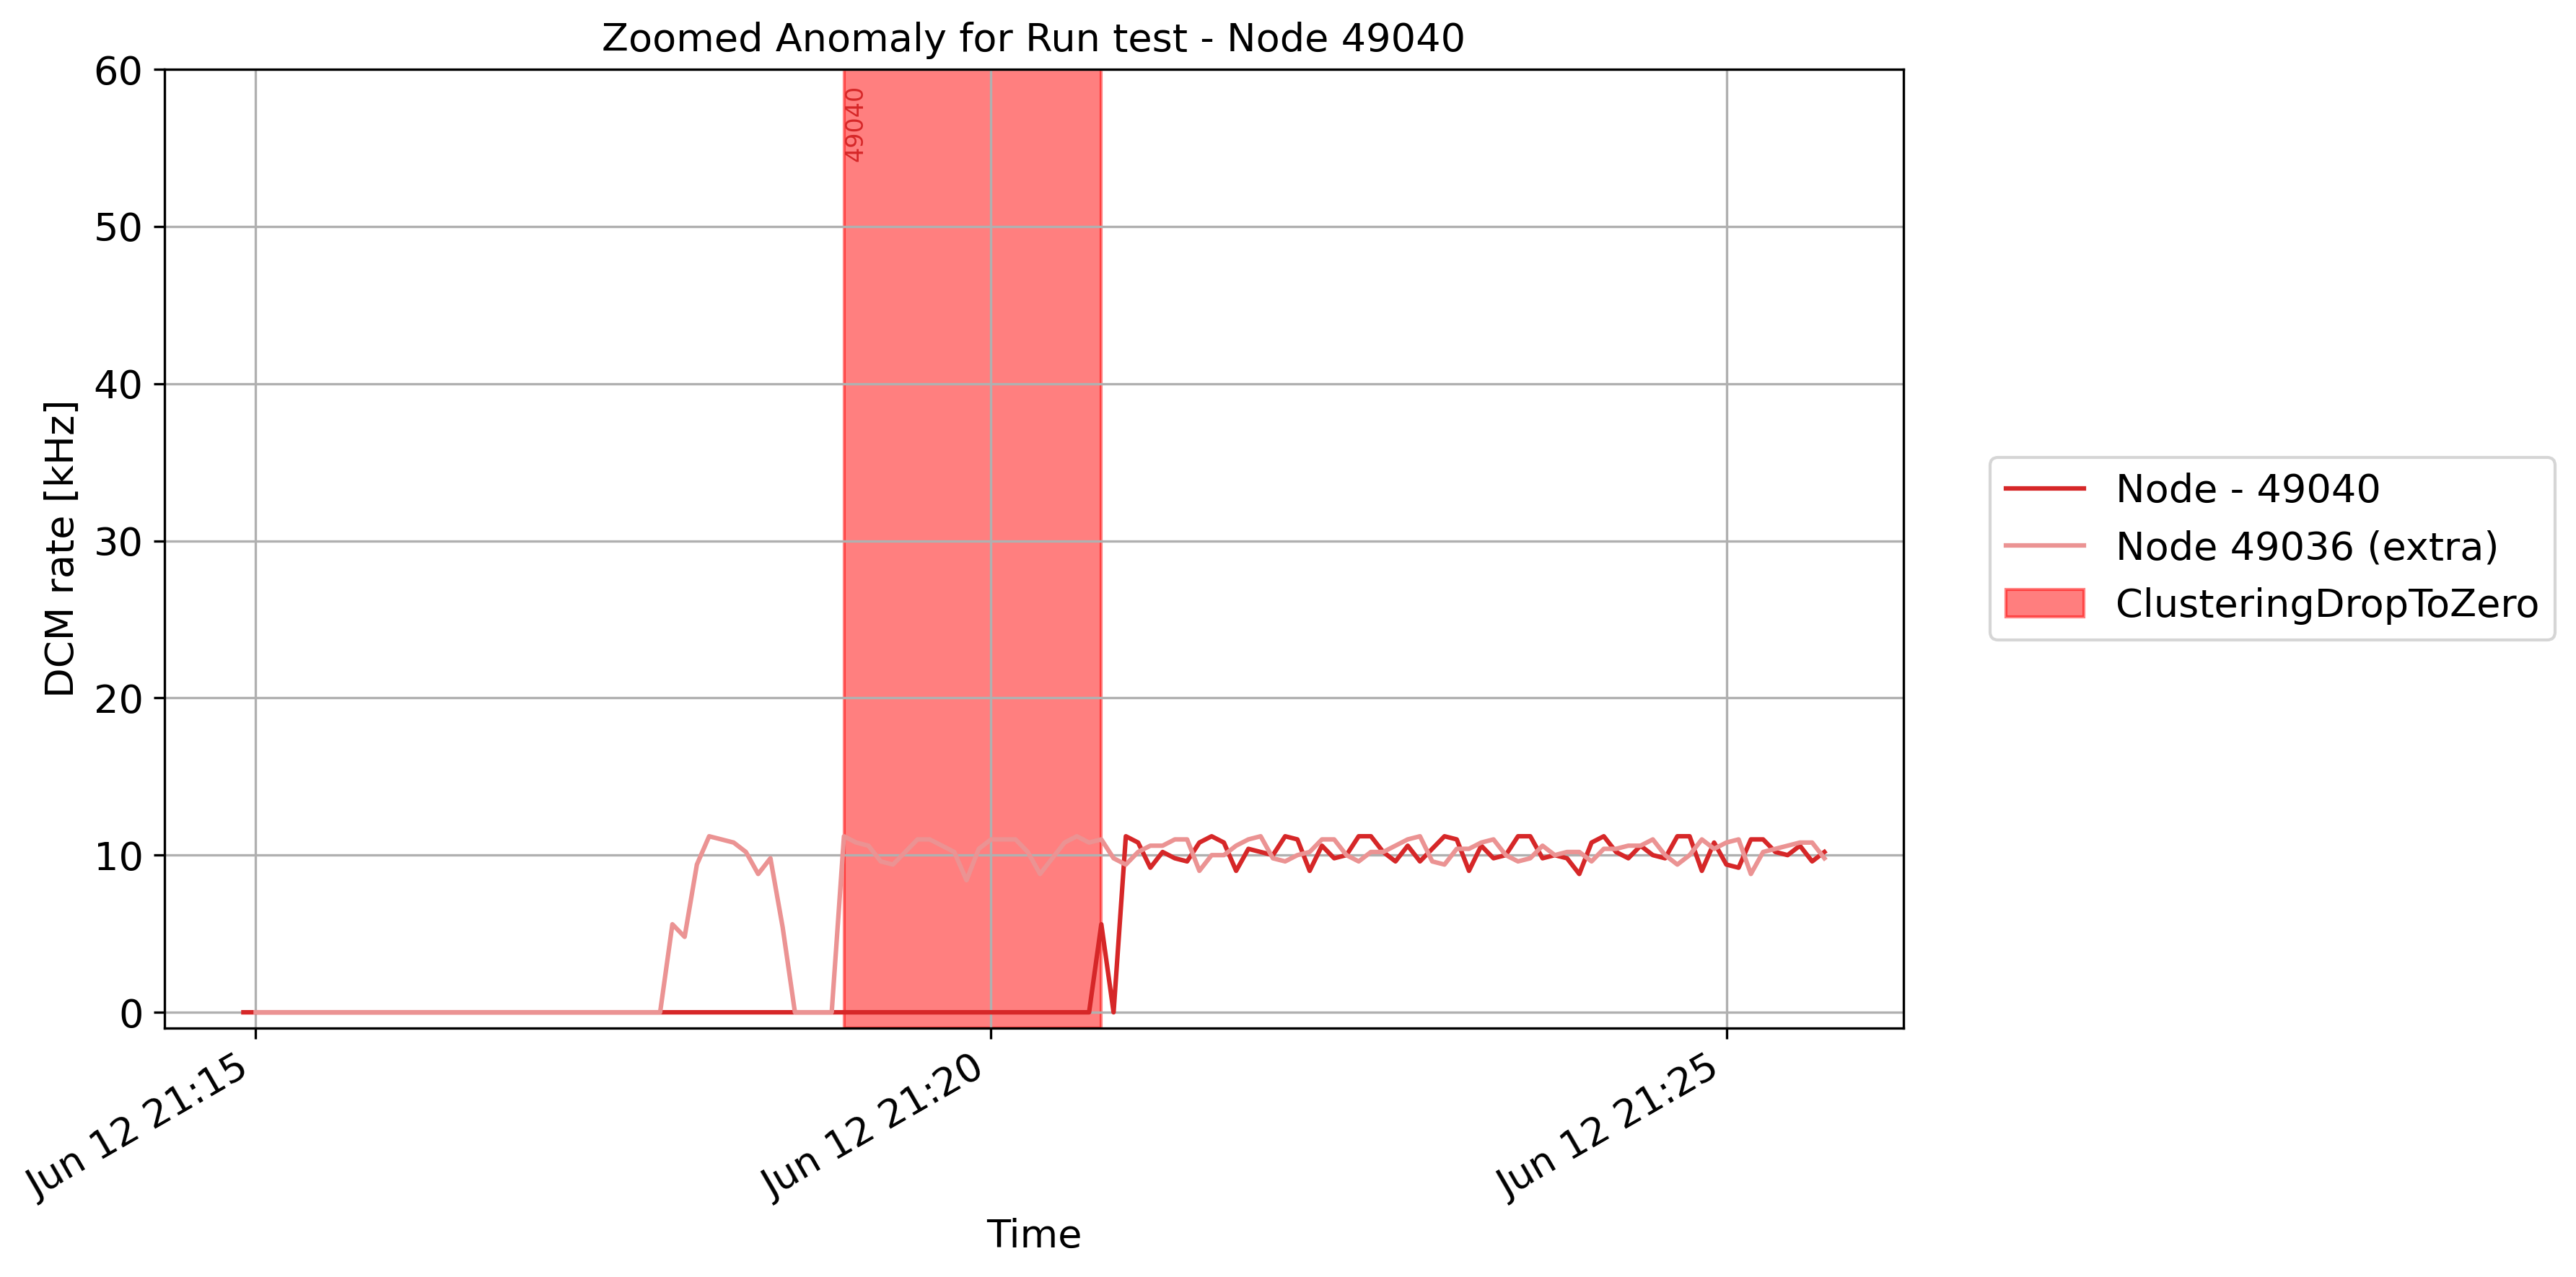

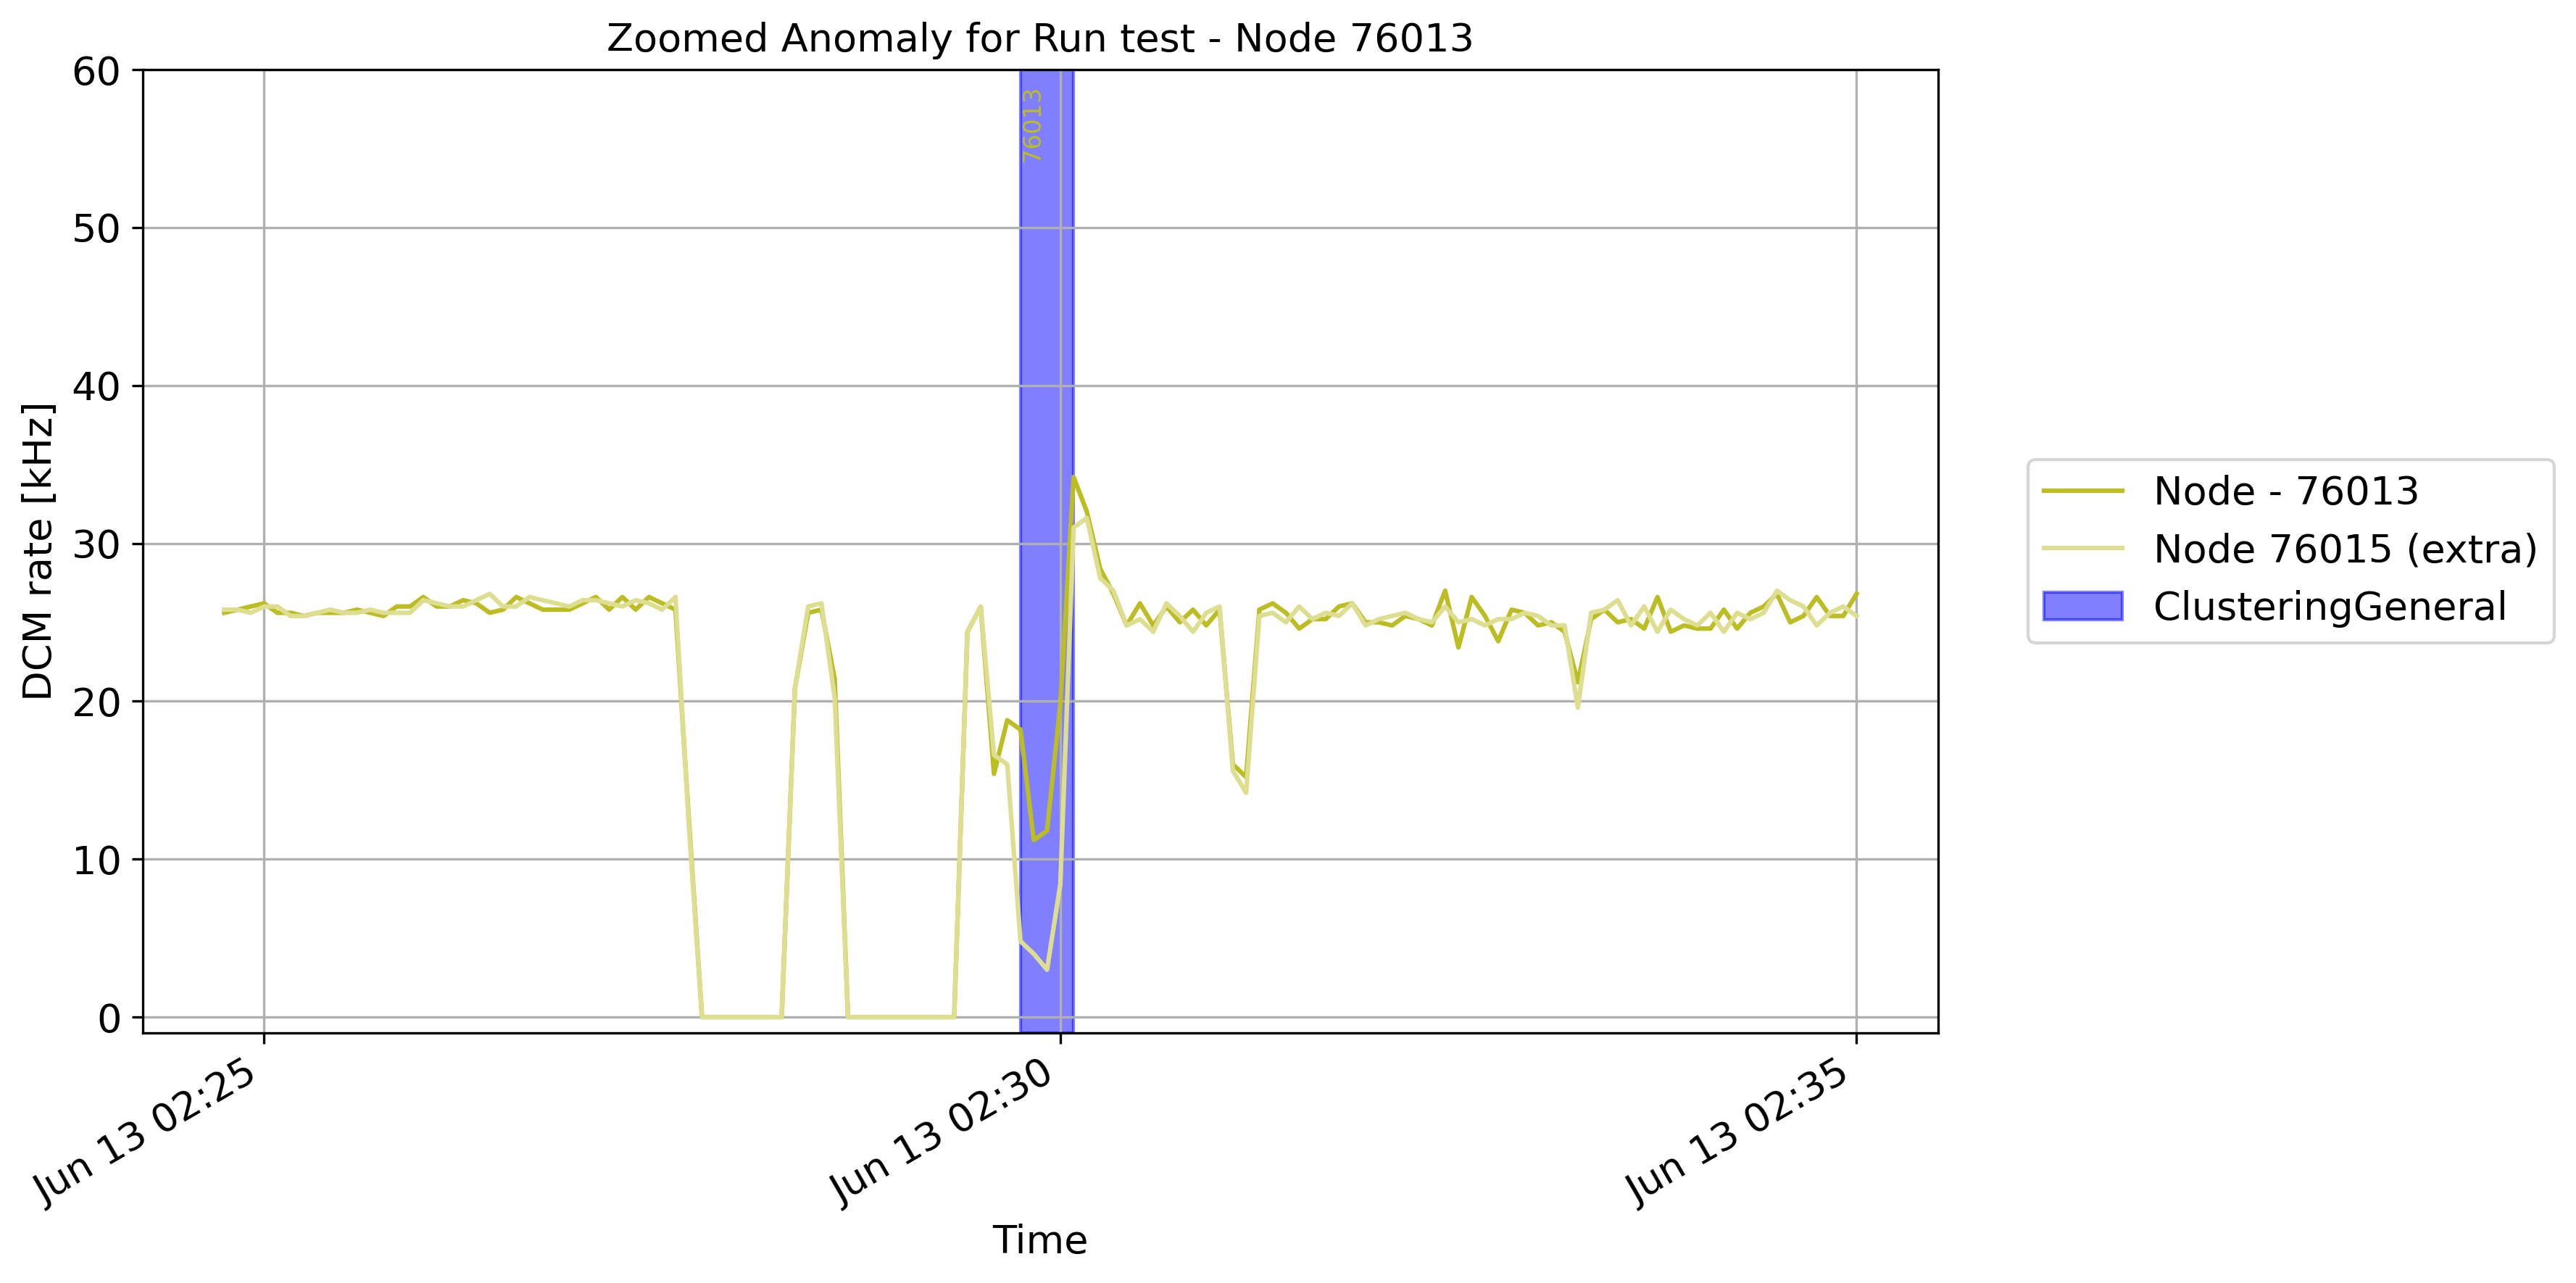

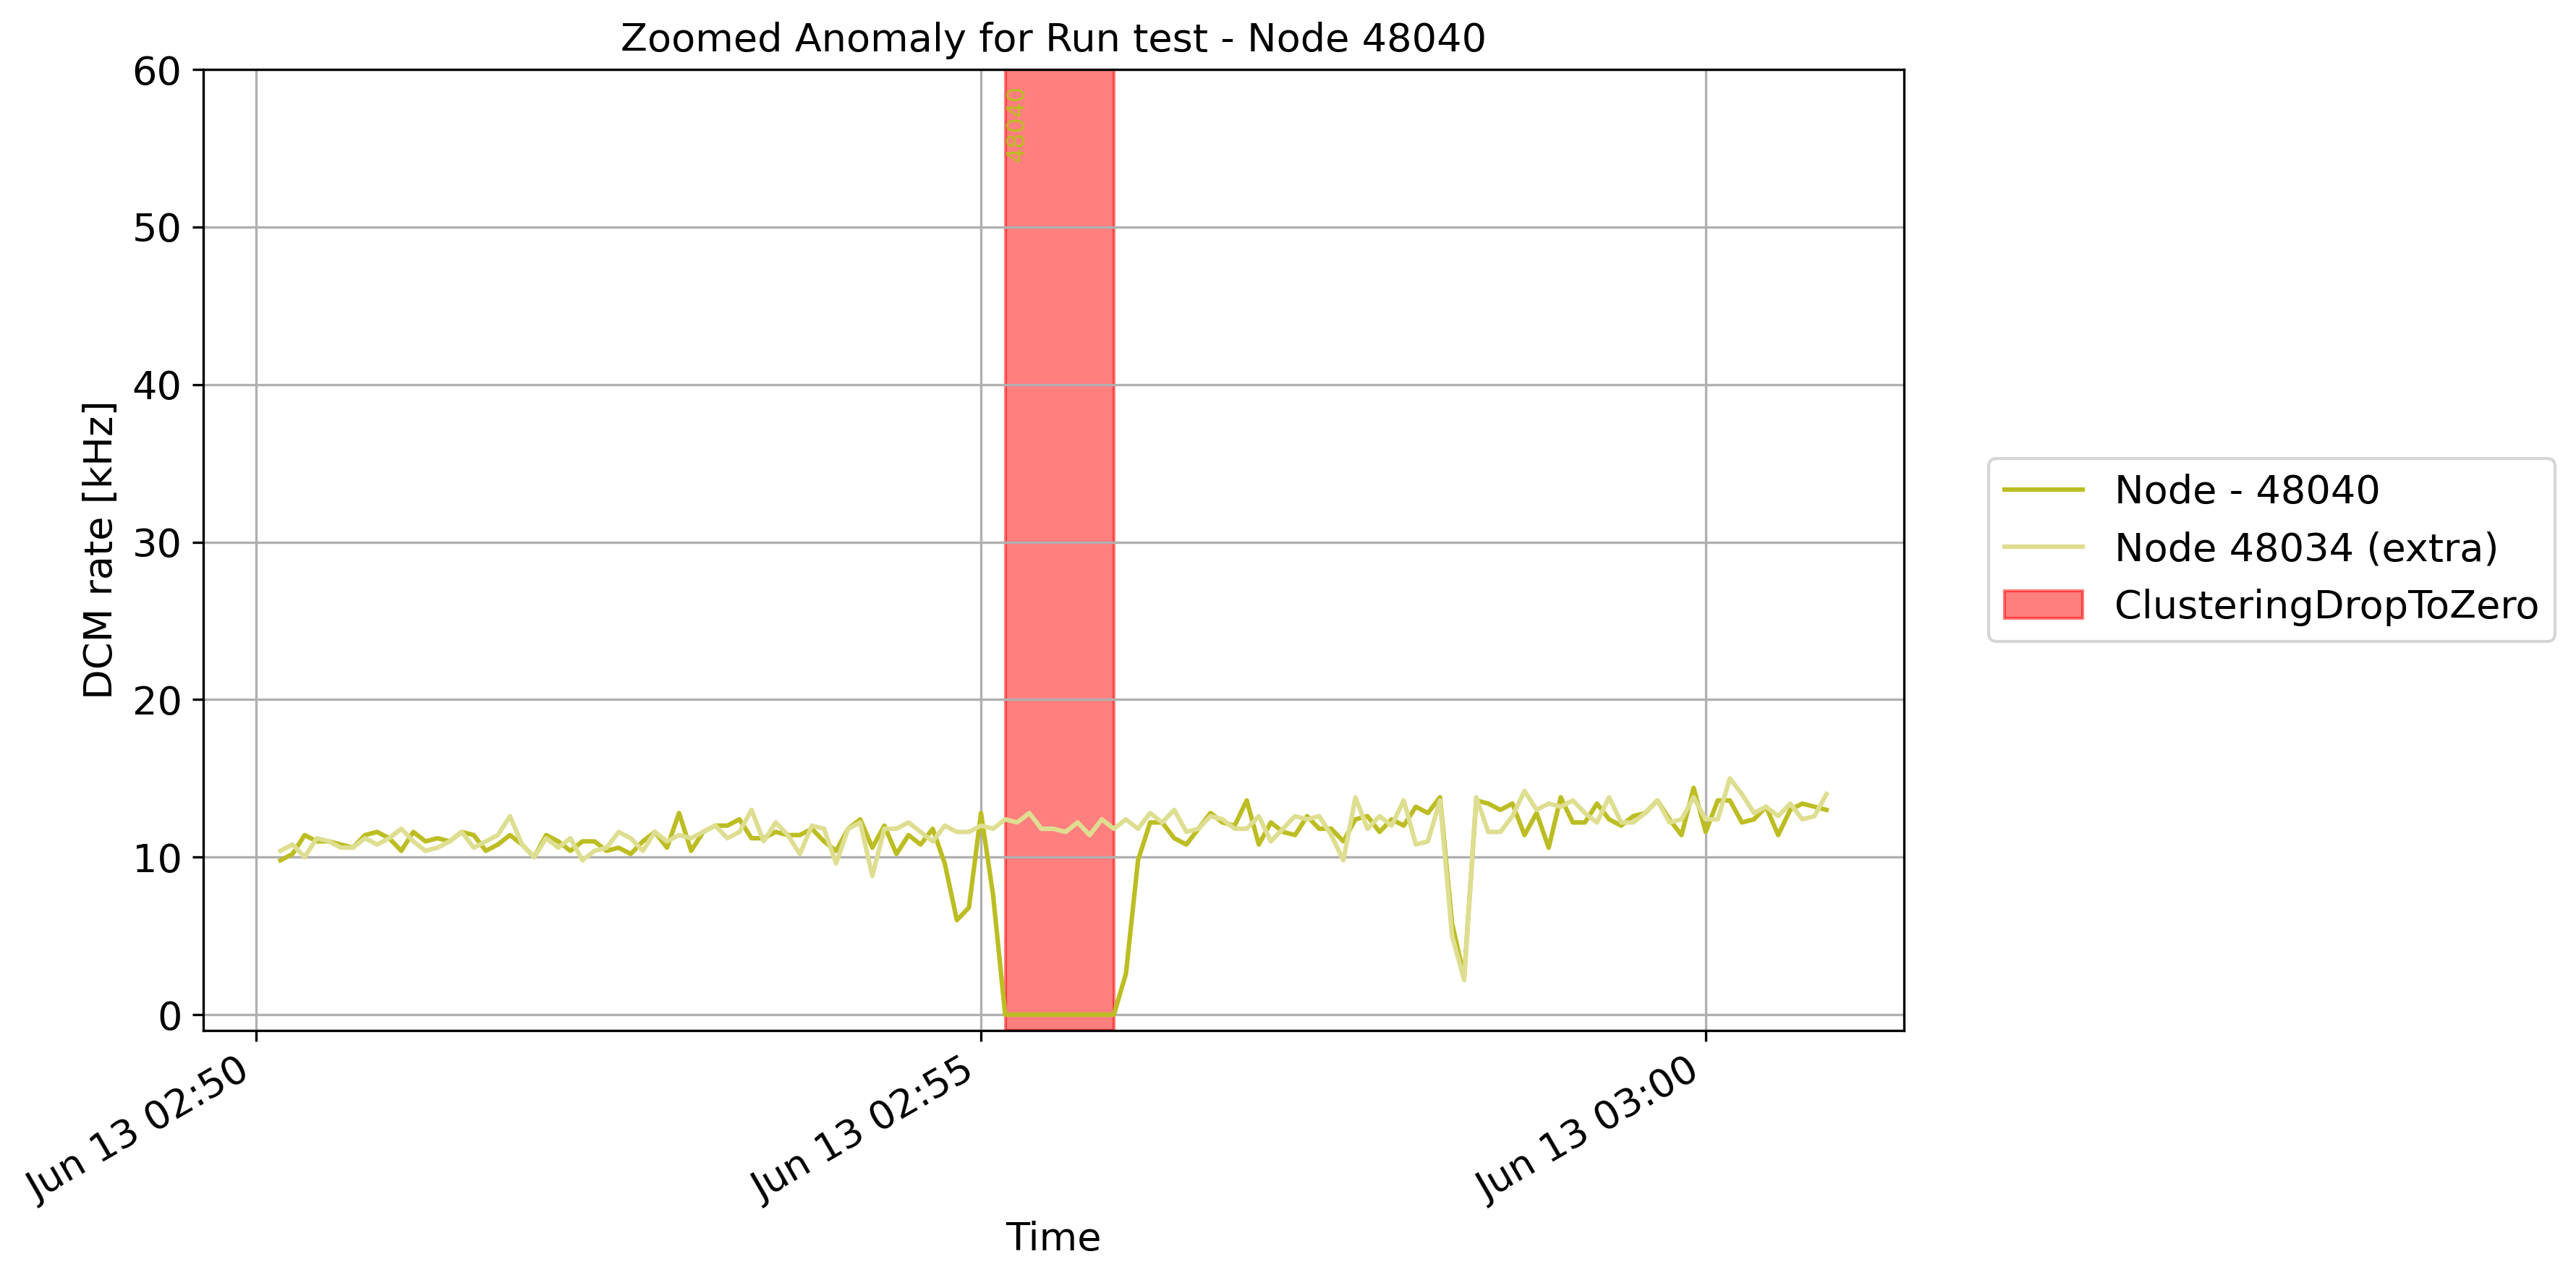

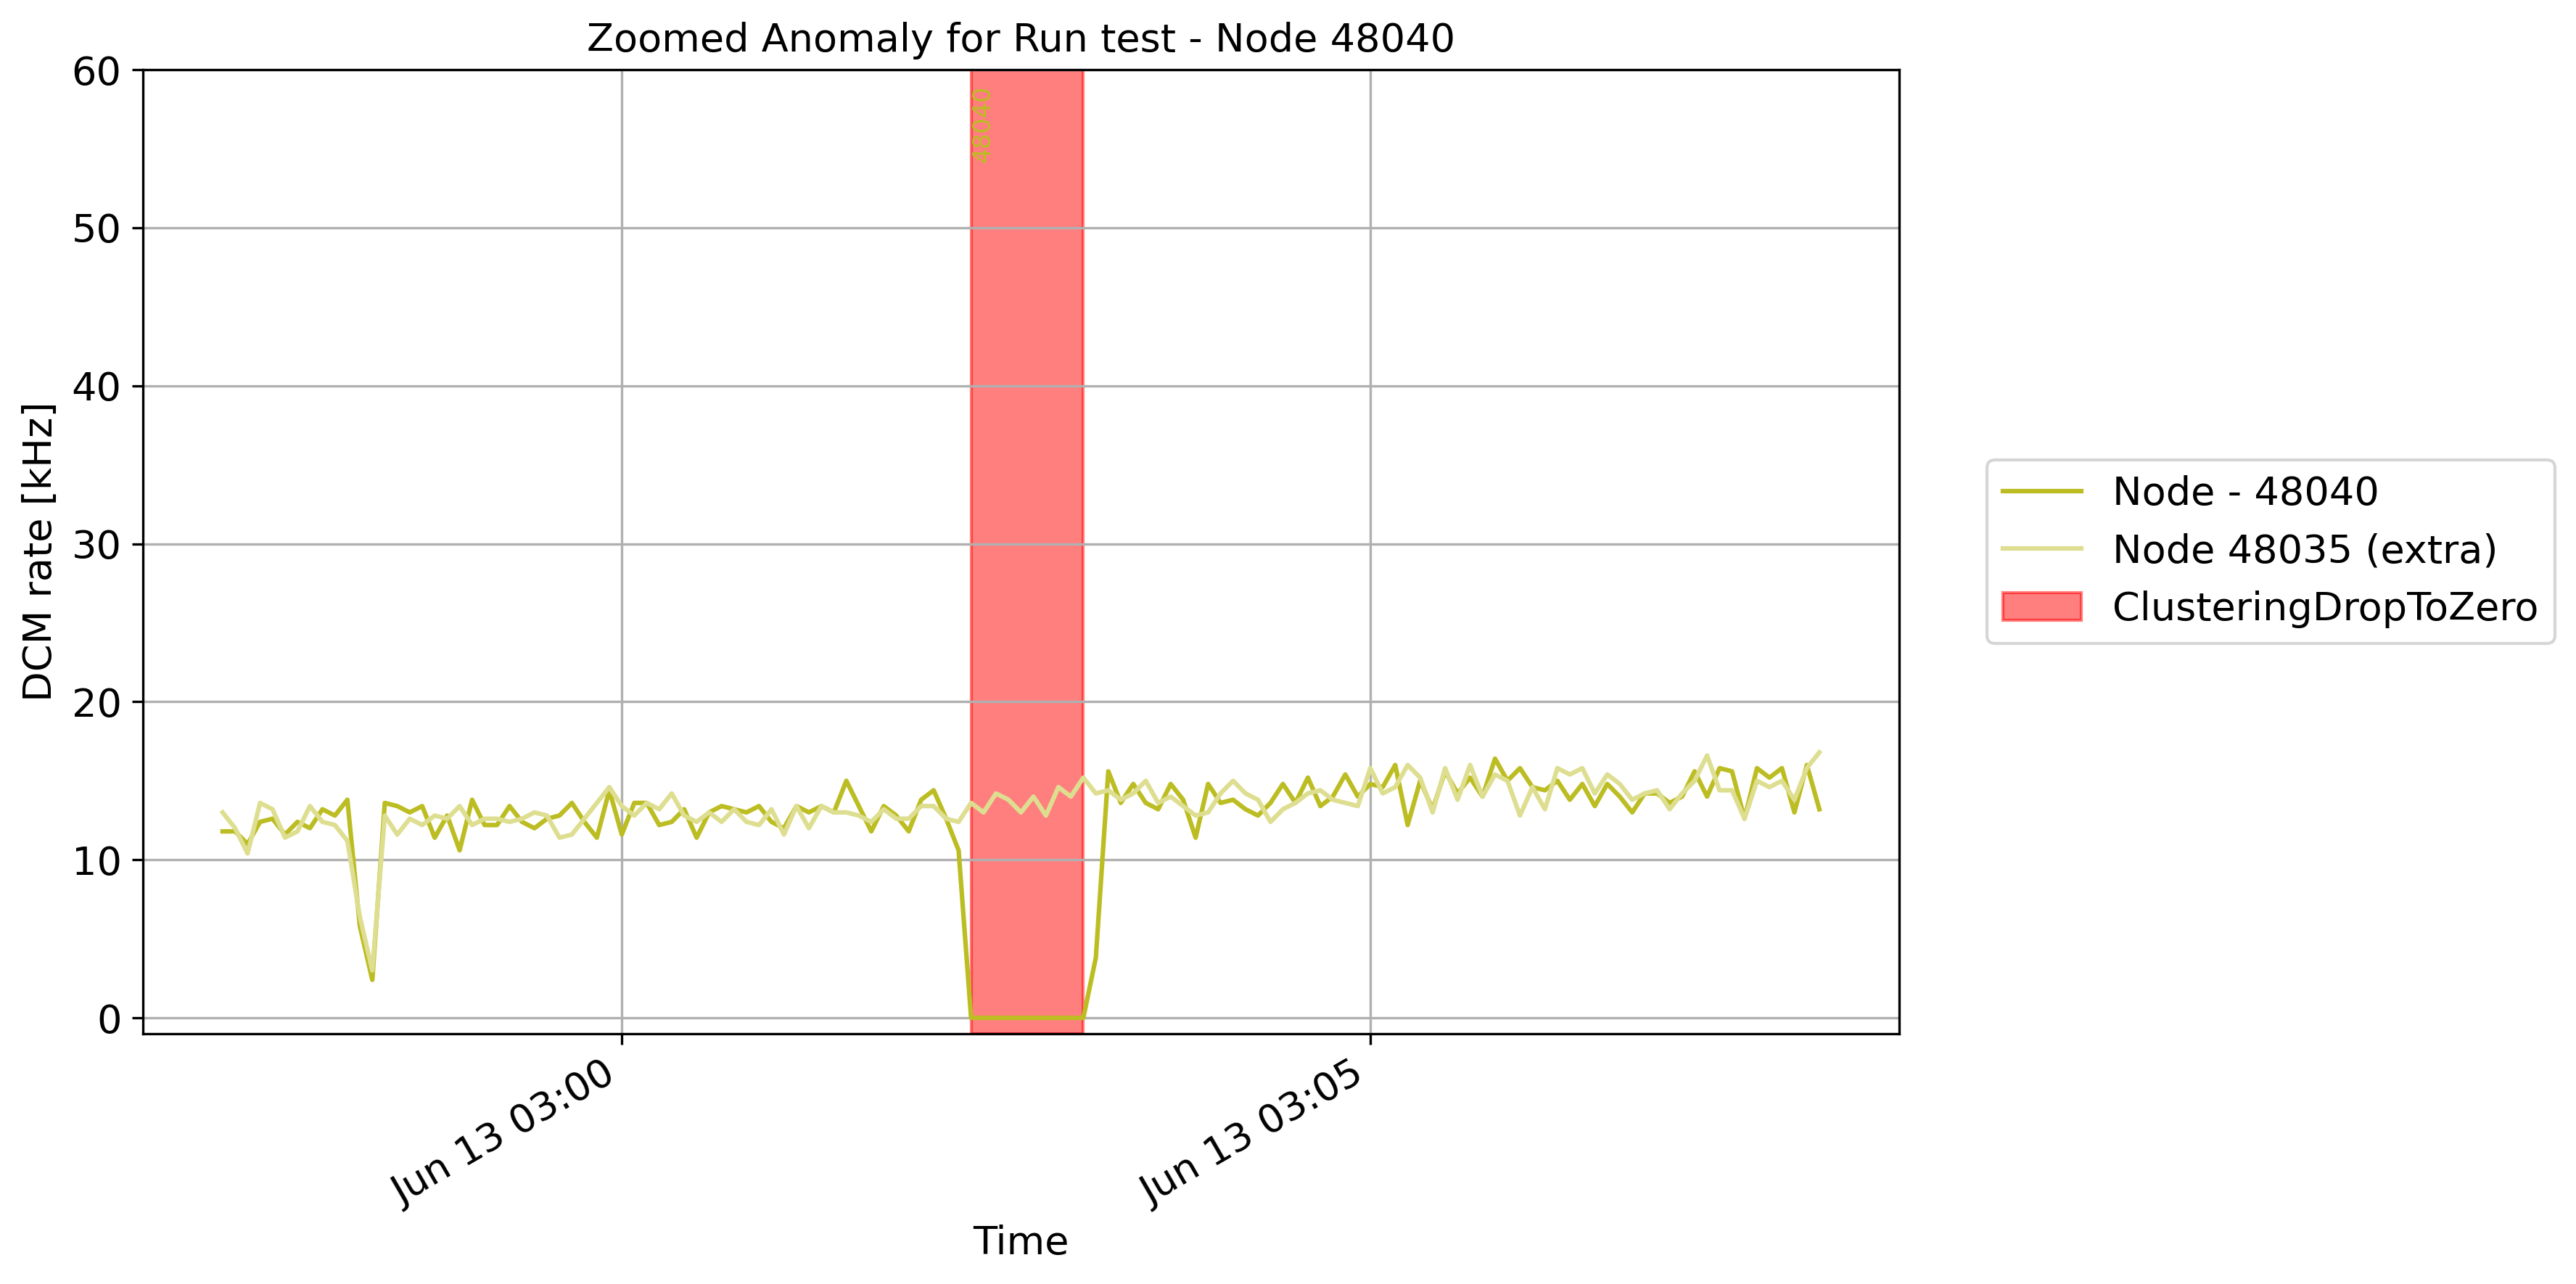

In [29]:
run_numbers = ['test']
#run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']

for run_number in run_numbers:
    plot_run(run_number)
    # Load anomaly data and dataset_df as before
    #json_file = f'output_notebook/run_{run_number}.json'
    #csv_file = f'data/hlt_data_pd_{run_number}.csv'
    json_file = f'output_notebook/{run_number}_dataset.json'
    csv_file = dataset_path
    if os.path.exists(json_file) and os.path.exists(csv_file):
        with open(json_file, 'r') as file: 
            anomaly_data = json.load(file)
        dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
        intervals = extract_intervals_for_all_machines(anomaly_data)
        plot_zoomed_anomalies(dataset_df, intervals, run_number)
        
        
        
# # In case we would like to create a PDF file to save all plots
# with PdfPages('anomaly_plots.pdf') as pdf:
#     for run_number in run_numbers:
#         plot_run(run_number, pdf)
#         # Load anomaly data and dataset_df as before
#         json_file = f'output_notebook/run_{run_number}.json'
#         csv_file = f'data/hlt_data_pd_{run_number}.csv'
#         if os.path.exists(json_file) and os.path.exists(csv_file):
#             with open(json_file, 'r') as file: 
#                 anomaly_data = json.load(file)
#             dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
#             dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
#             intervals = extract_intervals_for_all_machines(anomaly_data)
#             plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf)

This looks really good! <br/>
A little bit of digging is needed for the anomalies found for tpu-60009 on Jul 06 at 23h, as the extra machine (60021) is not being drawn. Maybe it was out for this run and not for others so the column was present but empty?